In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

from os.path import join
import pyvista as pv
import Logger

10.1


In [3]:
import importlib
importlib.reload(Utility)
from Utility import *

In [4]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        
        s.lpSmootherW = 0.1
        s.normalSmootherW = 0.1

        s.biLaplacian = False
        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [5]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1

# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
# cfg.sigma = 1e-5

# cfg.blurRange = 1e-4

# cfg.sigma = 1e-6
# cfg.blurRange = 1e-5

cfg.sigma = 1e-7
cfg.blurRange = 1e-7

cfg.plotStep = 10
cfg.numCams = 16
# cfg.learningRate = 1
# cfg.learningRate = 0.1
cfg.learningRate = 1

# cfg.normalShiftLevel = 10
cfg.normalShiftLevel = -3

# cfg.faces_per_pixel = 14
# cfg.faces_per_pixel = 30
# cfg.faces_per_pixel = 15
cfg.faces_per_pixel = 5

# cfg.imgSize = 2160   
cfg.imgSize = 1080
device = torch.device("cuda:0")
cfg.terminateLoss = 0.1

# cfg.lpSmootherW = 0.001
cfg.lpSmootherW = 0.0001

# cfg.normalSmootherW = 0.1
cfg.normalSmootherW = 0.1

renderSynth = Renderer(cfg)

cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
cfgRef.imgSize = 1080
renderRef = Renderer(cfgRef)

In [6]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Images\03052\Undist'
modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Models\03052.obj'
smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\SyntheticSilhouette'

In [7]:

actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


In [8]:
cams_torch['fl']

tensor([[1.7616, 1.7604],
        [1.7548, 1.7537],
        [1.7569, 1.7558],
        [1.7568, 1.7558],
        [1.7532, 1.7523],
        [1.7562, 1.7548],
        [1.7579, 1.7567],
        [1.7568, 1.7555],
        [1.7565, 1.7552],
        [1.7648, 1.7633],
        [1.7565, 1.7554],
        [1.7601, 1.7592],
        [1.7568, 1.7557],
        [1.7585, 1.7573],
        [1.7578, 1.7566],
        [1.7564, 1.7553]])

In [9]:
LNP = getLaplacian(smplshExampleMeshFile)

BiLNP = LNP @ LNP
if cfg.biLaplacian:
    LNP = torch.tensor(BiLNP,  dtype=torch.float32, device=device, requires_grad=False)
else:
    LNP = torch.tensor(LNP,  dtype=torch.float32, device=device, requires_grad=False)

In [10]:
cams = init_camera_batches(cams_torch, device)

In [11]:
verts, faces, aux = load_obj(modelFile)
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device)

nVerts = verts.shape[0]

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\pytorch3d-0.2.0-py3.6-win-amd64.egg\pytorch3d\io\obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [12]:
aux.normals.shape

torch.Size([6750, 3])

In [13]:
nNormals = normalizeNormals(aux.normals).to(device)

torch.Size([6750])


In [14]:
normalShiftRef = torch.tensor(np.full((nVerts,1), cfg.normalShiftLevel), dtype=torch.float32, device=device)

In [15]:
nNormals

tensor([[ 0.7431, -0.5174,  0.4244],
        [ 0.6826, -0.5591,  0.4706],
        [ 0.8415, -0.3859,  0.3782],
        ...,
        [ 0.3730, -0.8021,  0.4664],
        [ 0.4670, -0.6423, -0.6077],
        [-0.9316, -0.3278, -0.1569]], device='cuda:0')

In [16]:
modifiedVertsRef = verts + normalShiftRef * nNormals
meshRef = Meshes(
                verts=[modifiedVertsRef],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )

In [17]:
def visualize2DResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                if pytorch3DImg:
                    imgAlpha = images[iCam][0,...,3]
                else:
                    imgAlpha = images[iCam]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam])
#                     fgMask = np.logical_not(np.where())
                    for iChannel in range(3):
                        img[..., iChannel] = np.where(imgAlpha, imgAlpha, backGroundImages[iCam][...,iChannel])
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [18]:
normalShift = torch.tensor(np.full((nVerts,1), 0), dtype=torch.float32, requires_grad = True, device=device)

In [19]:
modifiedVerts = verts + normalShift * nNormals
mesh = Meshes(
                verts=[modifiedVerts.to(device)],   
                faces=[faces_idx.to(device)], 
#                 textures=textures.to(device)
            )

In [20]:
modifiedVerts.requires_grad

True

In [26]:
expName = 'LapOnNShift_' + 'Shift' + str(cfg.normalShiftLevel) +'_Sig' + str(cfg.sigma) + '_BR' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams' + str(cfg.numCams)+ 'ImS' + str(cfg.imgSize) + "_LR" + str(cfg.learningRate) + "_LW" + str(cfg.lpSmootherW) + "_NW" + str(cfg.normalSmootherW) + '_BiLap' + str(cfg.biLaplacian)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump({"CfgSynth":cfg.__dict__, "CfgRef":cfgRef.__dict__,}, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\SyntheticSilhouette\LapOnNShift_Shift-3_Sig1e-07_BR1e-07_Fpp5_NCams16ImS1080_LR1_LW0.0001_NW0.1_BiLapFalse


<IPython.core.display.Javascript object>


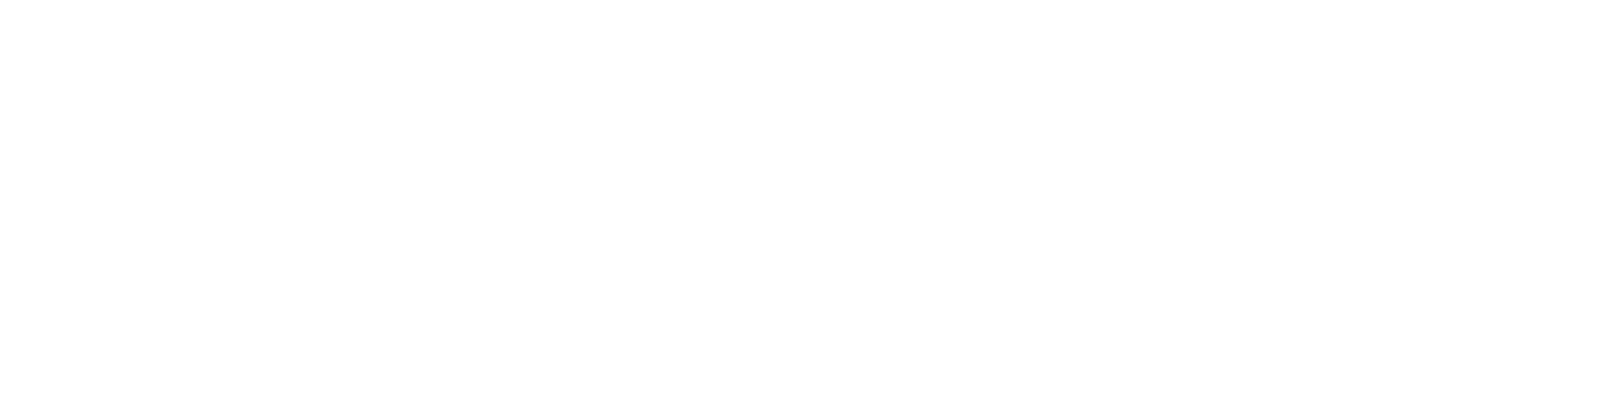

In [27]:
imagesRef = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderRef.renderer(meshRef,  cameras=cams[iCam]).cpu().detach().numpy()
        image_cur[np.where(image_cur)] = 1        
        imagesRef.append(image_cur)
visualize2DResults(imagesRef, outImgFile = join(outFolderForExperiment, 'Target.png'))

<IPython.core.display.Javascript object>


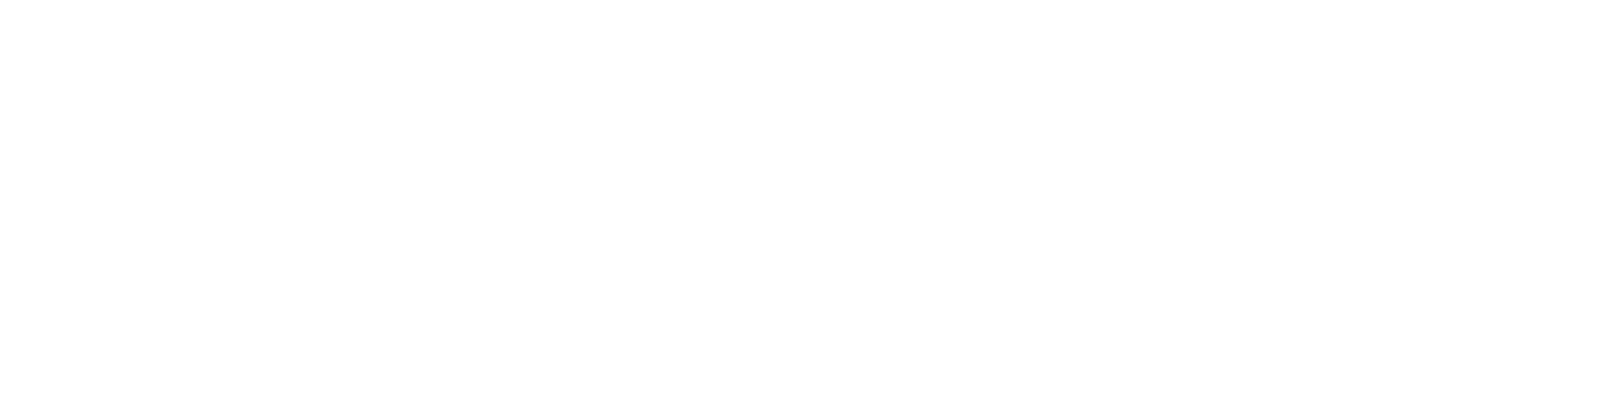

Before release: active_bytes.all.current: 203.942912 MB
After release: active_bytes.all.current: 203.942912 MB


In [28]:
images = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())
visualize2DResults(images)
showCudaMemUsage(device)

In [29]:
diffImages = []
loss = 0
for iCam in range(len(cams)):
    imgDiff = np.abs(images[iCam] - imagesRef[iCam])
    diffImages.append(imgDiff)
    
    loss += 1 -np.sum(np.abs(images[iCam][..., 3] * imagesRef[iCam][..., 3])) / np.sum(np.abs(imagesRef[iCam][..., 3] + images[iCam][..., 3] - imagesRef[iCam][..., 3] * images[iCam][..., 3]))

In [30]:
# print("mesh_laplacian_smoothing", mesh_laplacian_smoothing(mesh))
print("mesh_normal_consistency", mesh_normal_consistency(mesh))

mesh_normal_consistency tensor(0.0479, device='cuda:0')


In [31]:
a = np.array([[2,2], [2,2]])
print(np.linalg.norm(a.flatten(), ord=1))

8.0


<IPython.core.display.Javascript object>


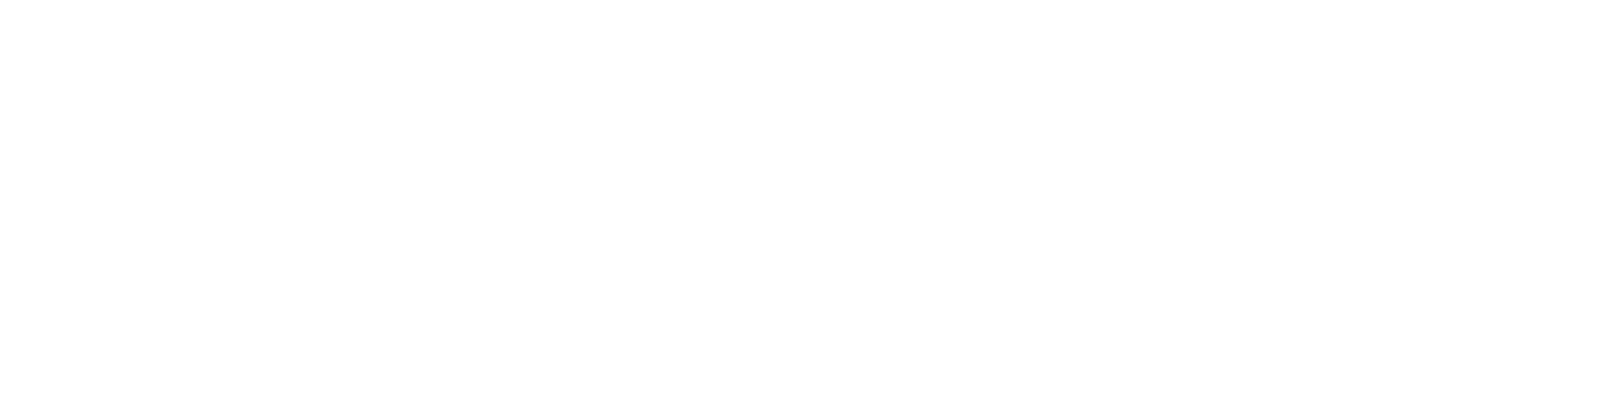

In [32]:
visualize2DResults(diffImages)

In [33]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

# cfg.learningRate = 0.05
# cfg.learningRate = 0.1
# cfg.plotStep = 10
# cfg.learningRate = 3

In [34]:
optimizer = torch.optim.Adam([normalShift], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [35]:
torch.cuda.empty_cache()
showCudaMemUsage(device)


Before release: active_bytes.all.current: 204.754432 MB
After release: active_bytes.all.current: 204.754432 MB


In [36]:
print(normalShift.transpose(0,1) @ LNP @ normalShift)

tensor([[0.]], device='cuda:0', grad_fn=<MmBackward>)


C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


2020-06-04 20:50:47,208 logger INFO loss 0.99, 3D Dis:  3.00mm, shiftDiff: 17740.703125, MemUsed:232.37
Before release: active_bytes.all.current: 232.370176 MB
After release: active_bytes.all.current: 232.370176 MB


<IPython.core.display.Javascript object>


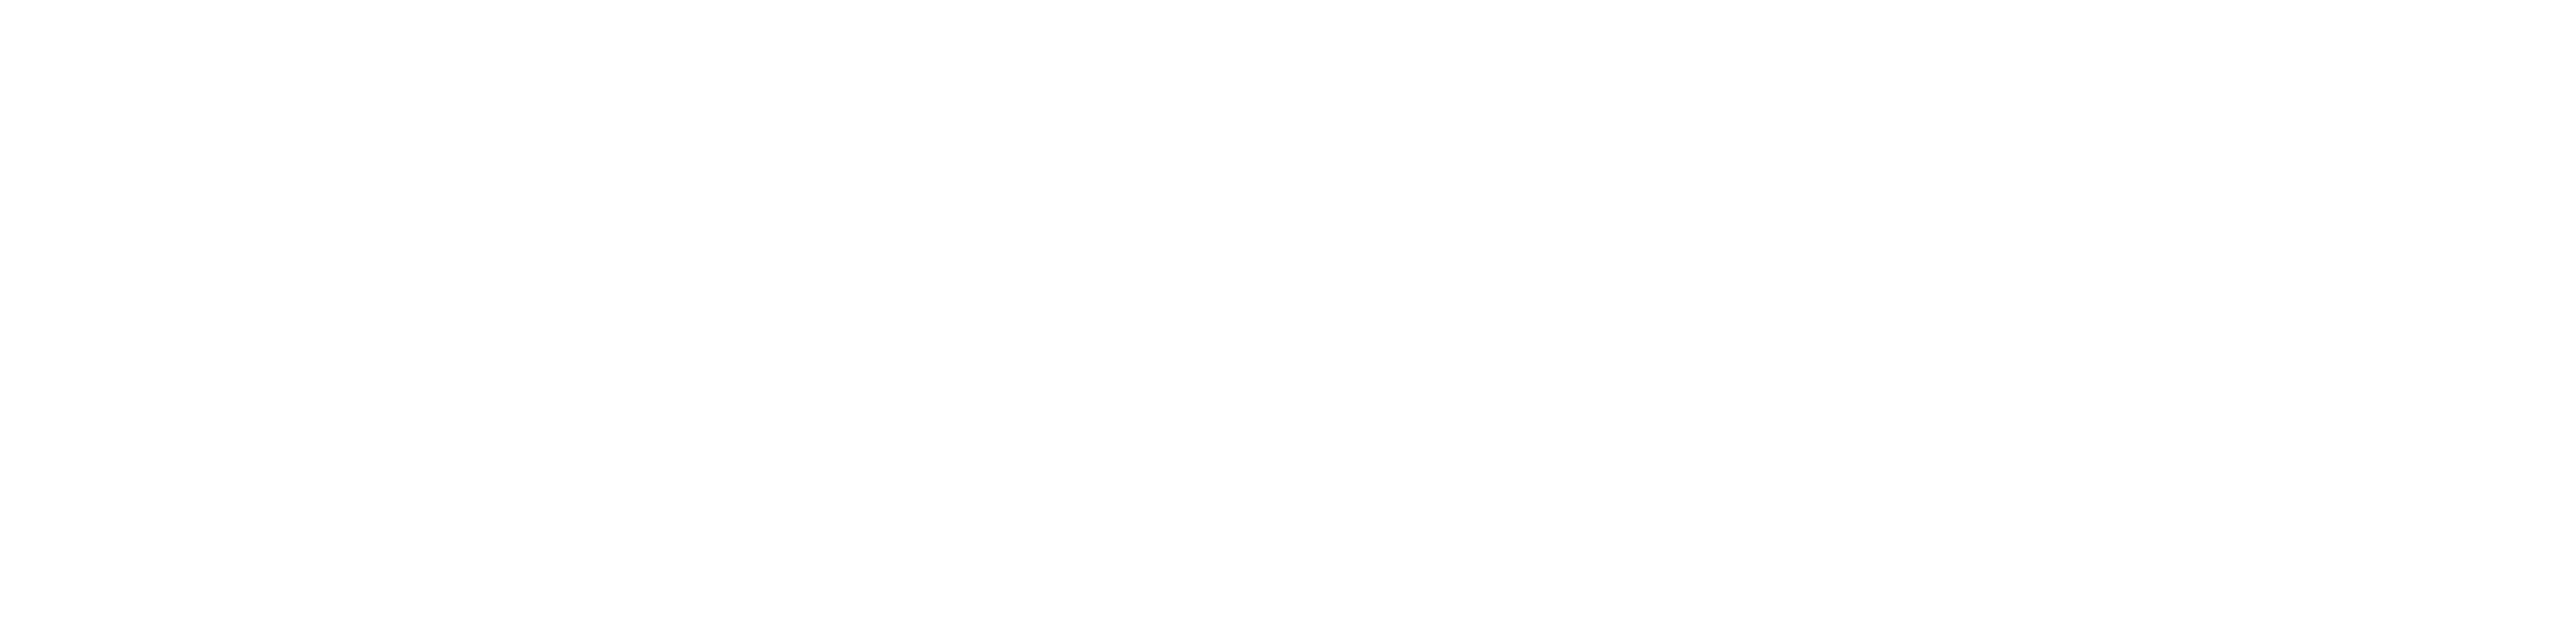

2020-06-04 20:51:09,296 logger INFO loss 2.65, 3D Dis:  2.63mm, shiftDiff: 16696.746094, MemUsed:232.37
2020-06-04 20:51:14,453 logger INFO loss 1.37, 3D Dis:  2.47mm, shiftDiff: 16163.681641, MemUsed:232.37
2020-06-04 20:51:19,652 logger INFO loss 1.38, 3D Dis:  2.39mm, shiftDiff: 16133.709961, MemUsed:232.37
2020-06-04 20:51:24,821 logger INFO loss 1.69, 3D Dis:  2.39mm, shiftDiff: 15836.589844, MemUsed:232.37
2020-06-04 20:51:30,038 logger INFO loss 1.51, 3D Dis:  2.35mm, shiftDiff: 15428.250000, MemUsed:232.37
2020-06-04 20:51:35,210 logger INFO loss 1.15, 3D Dis:  2.29mm, shiftDiff: 14991.668945, MemUsed:232.37
2020-06-04 20:51:40,419 logger INFO loss 0.96, 3D Dis:  2.22mm, shiftDiff: 14563.160156, MemUsed:232.37
2020-06-04 20:51:45,676 logger INFO loss 1.01, 3D Dis:  2.16mm, shiftDiff: 14161.556641, MemUsed:232.37
2020-06-04 20:51:50,893 logger INFO loss 1.10, 3D Dis:  2.10mm, shiftDiff: 13801.400391, MemUsed:232.37
2020-06-04 20:51:56,150 logger INFO loss 1.06, 3D Dis:  2.04mm, 

<IPython.core.display.Javascript object>


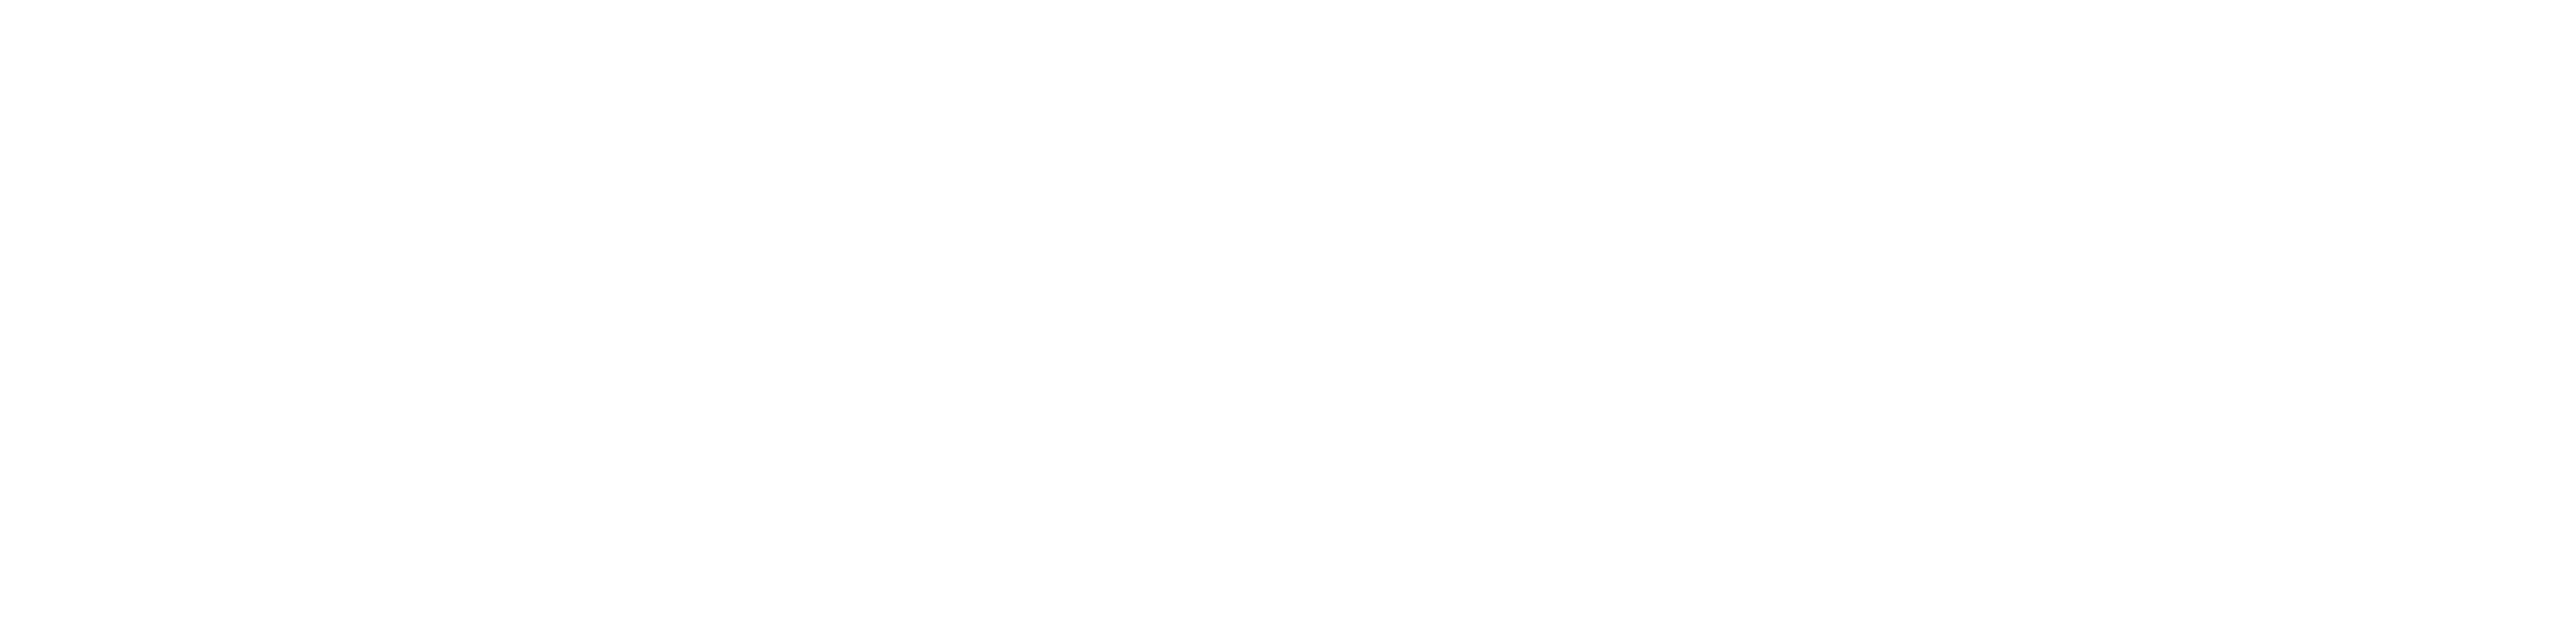

2020-06-04 20:52:18,369 logger INFO loss 0.92, 3D Dis:  1.99mm, shiftDiff: 13134.513672, MemUsed:232.37
2020-06-04 20:52:23,652 logger INFO loss 0.80, 3D Dis:  1.95mm, shiftDiff: 12820.234375, MemUsed:232.37
2020-06-04 20:52:28,850 logger INFO loss 0.76, 3D Dis:  1.90mm, shiftDiff: 12515.644531, MemUsed:232.37
2020-06-04 20:52:34,113 logger INFO loss 0.79, 3D Dis:  1.85mm, shiftDiff: 12214.255859, MemUsed:232.37
2020-06-04 20:52:39,338 logger INFO loss 0.81, 3D Dis:  1.81mm, shiftDiff: 11907.942383, MemUsed:232.37
2020-06-04 20:52:44,751 logger INFO loss 0.78, 3D Dis:  1.76mm, shiftDiff: 11607.677734, MemUsed:232.37
2020-06-04 20:52:49,990 logger INFO loss 0.71, 3D Dis:  1.72mm, shiftDiff: 11311.998047, MemUsed:232.37
2020-06-04 20:52:55,264 logger INFO loss 0.66, 3D Dis:  1.68mm, shiftDiff: 11024.384766, MemUsed:232.37
2020-06-04 20:53:00,644 logger INFO loss 0.64, 3D Dis:  1.63mm, shiftDiff: 10744.630859, MemUsed:232.37
2020-06-04 20:53:05,970 logger INFO loss 0.65, 3D Dis:  1.59mm, 

<IPython.core.display.Javascript object>


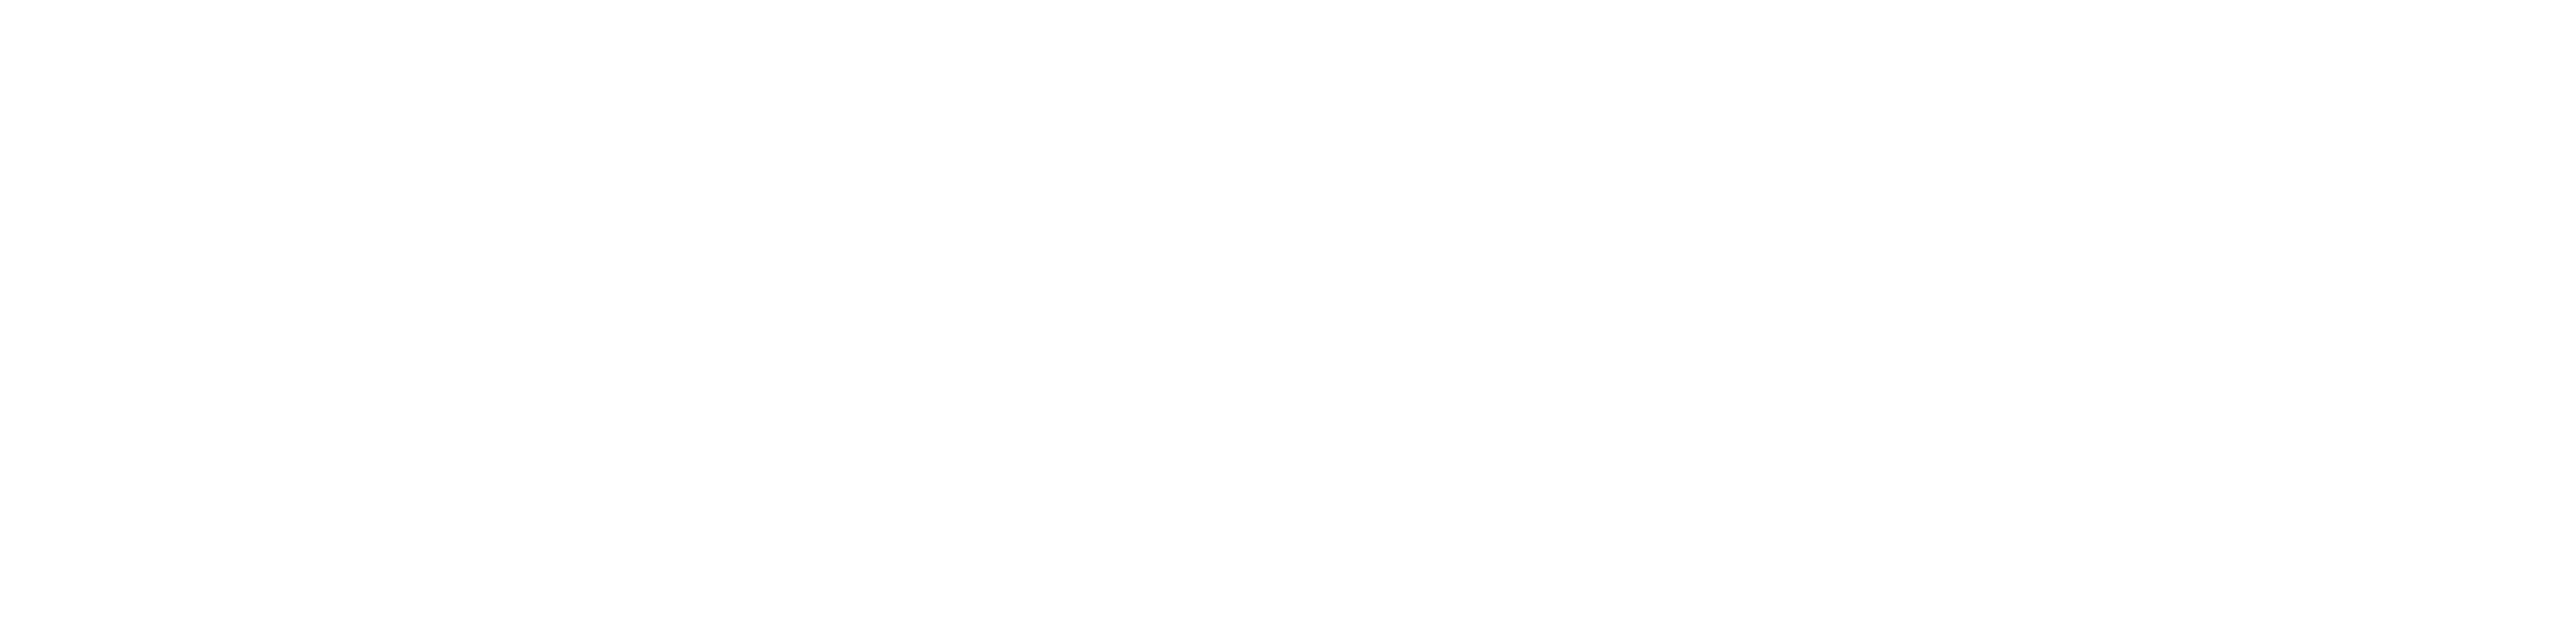

2020-06-04 20:53:28,428 logger INFO loss 0.65, 3D Dis:  1.55mm, shiftDiff: 10236.032227, MemUsed:232.37
2020-06-04 20:53:33,651 logger INFO loss 0.63, 3D Dis:  1.52mm, shiftDiff: 10003.467773, MemUsed:232.37
2020-06-04 20:53:38,896 logger INFO loss 0.60, 3D Dis:  1.48mm, shiftDiff: 9780.742188, MemUsed:232.37
2020-06-04 20:53:44,148 logger INFO loss 0.58, 3D Dis:  1.45mm, shiftDiff: 9570.025391, MemUsed:232.37
2020-06-04 20:53:49,491 logger INFO loss 0.57, 3D Dis:  1.42mm, shiftDiff: 9369.990234, MemUsed:232.37
2020-06-04 20:53:54,787 logger INFO loss 0.57, 3D Dis:  1.39mm, shiftDiff: 9173.296875, MemUsed:232.37
2020-06-04 20:54:00,154 logger INFO loss 0.56, 3D Dis:  1.36mm, shiftDiff: 8980.568359, MemUsed:232.37
2020-06-04 20:54:05,498 logger INFO loss 0.55, 3D Dis:  1.33mm, shiftDiff: 8794.476562, MemUsed:232.37
2020-06-04 20:54:10,869 logger INFO loss 0.53, 3D Dis:  1.30mm, shiftDiff: 8612.494141, MemUsed:232.37
2020-06-04 20:54:16,259 logger INFO loss 0.52, 3D Dis:  1.28mm, shiftDi

<IPython.core.display.Javascript object>


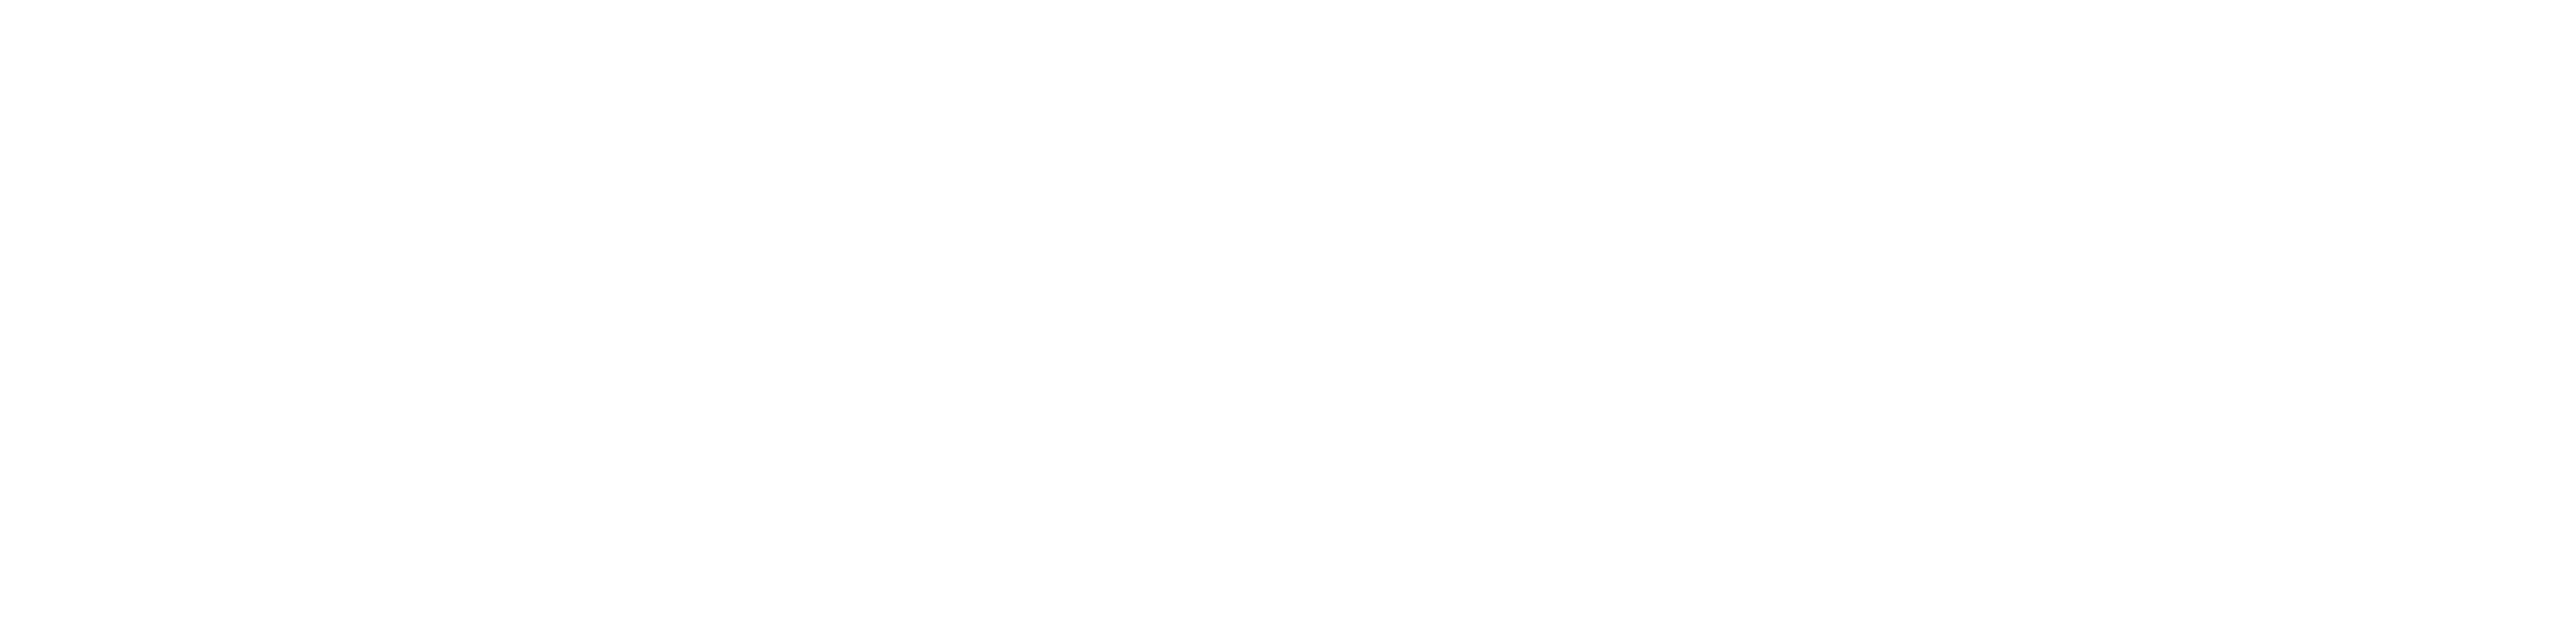

2020-06-04 20:54:38,665 logger INFO loss 0.52, 3D Dis:  1.25mm, shiftDiff: 8252.738281, MemUsed:232.37
2020-06-04 20:54:43,896 logger INFO loss 0.52, 3D Dis:  1.22mm, shiftDiff: 8076.783203, MemUsed:232.37
2020-06-04 20:54:49,263 logger INFO loss 0.51, 3D Dis:  1.20mm, shiftDiff: 7904.407227, MemUsed:232.37
2020-06-04 20:54:54,675 logger INFO loss 0.50, 3D Dis:  1.17mm, shiftDiff: 7736.660156, MemUsed:232.37
2020-06-04 20:55:00,126 logger INFO loss 0.50, 3D Dis:  1.15mm, shiftDiff: 7570.657715, MemUsed:232.37
2020-06-04 20:55:05,493 logger INFO loss 0.49, 3D Dis:  1.12mm, shiftDiff: 7403.210938, MemUsed:232.37
2020-06-04 20:55:10,813 logger INFO loss 0.49, 3D Dis:  1.10mm, shiftDiff: 7231.406250, MemUsed:232.37
2020-06-04 20:55:16,222 logger INFO loss 0.49, 3D Dis:  1.07mm, shiftDiff: 7054.804688, MemUsed:232.37
2020-06-04 20:55:21,564 logger INFO loss 0.48, 3D Dis:  1.05mm, shiftDiff: 6877.640625, MemUsed:232.37
2020-06-04 20:55:26,965 logger INFO loss 0.48, 3D Dis:  1.02mm, shiftDiff

<IPython.core.display.Javascript object>


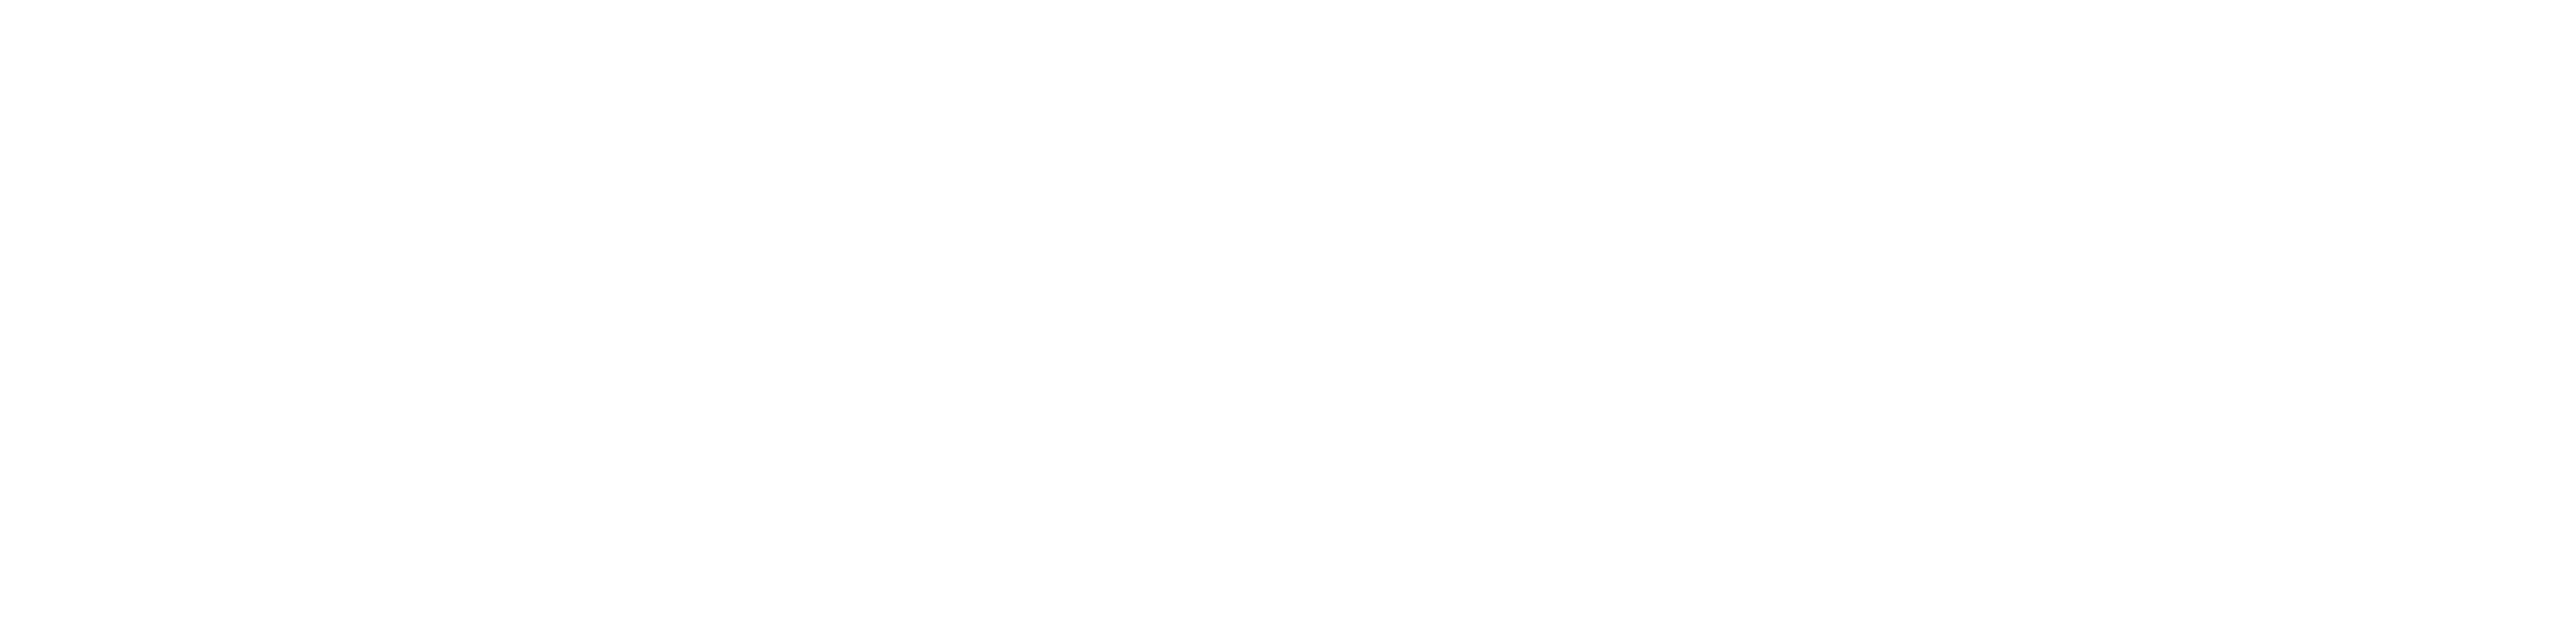

2020-06-04 20:55:49,418 logger INFO loss 0.47, 3D Dis:  0.99mm, shiftDiff: 6529.161133, MemUsed:232.37
2020-06-04 20:55:54,834 logger INFO loss 0.47, 3D Dis:  0.97mm, shiftDiff: 6357.061523, MemUsed:232.37
2020-06-04 20:56:00,193 logger INFO loss 0.47, 3D Dis:  0.94mm, shiftDiff: 6187.467773, MemUsed:232.37
2020-06-04 20:56:05,515 logger INFO loss 0.46, 3D Dis:  0.92mm, shiftDiff: 6019.169922, MemUsed:232.37
2020-06-04 20:56:10,862 logger INFO loss 0.46, 3D Dis:  0.89mm, shiftDiff: 5850.880859, MemUsed:232.37
2020-06-04 20:56:16,211 logger INFO loss 0.45, 3D Dis:  0.87mm, shiftDiff: 5681.388672, MemUsed:232.37
2020-06-04 20:56:21,640 logger INFO loss 0.45, 3D Dis:  0.84mm, shiftDiff: 5513.397461, MemUsed:232.37
2020-06-04 20:56:26,976 logger INFO loss 0.45, 3D Dis:  0.82mm, shiftDiff: 5350.984375, MemUsed:232.37
2020-06-04 20:56:32,431 logger INFO loss 0.45, 3D Dis:  0.79mm, shiftDiff: 5192.636719, MemUsed:232.37
2020-06-04 20:56:37,798 logger INFO loss 0.44, 3D Dis:  0.77mm, shiftDiff

<IPython.core.display.Javascript object>


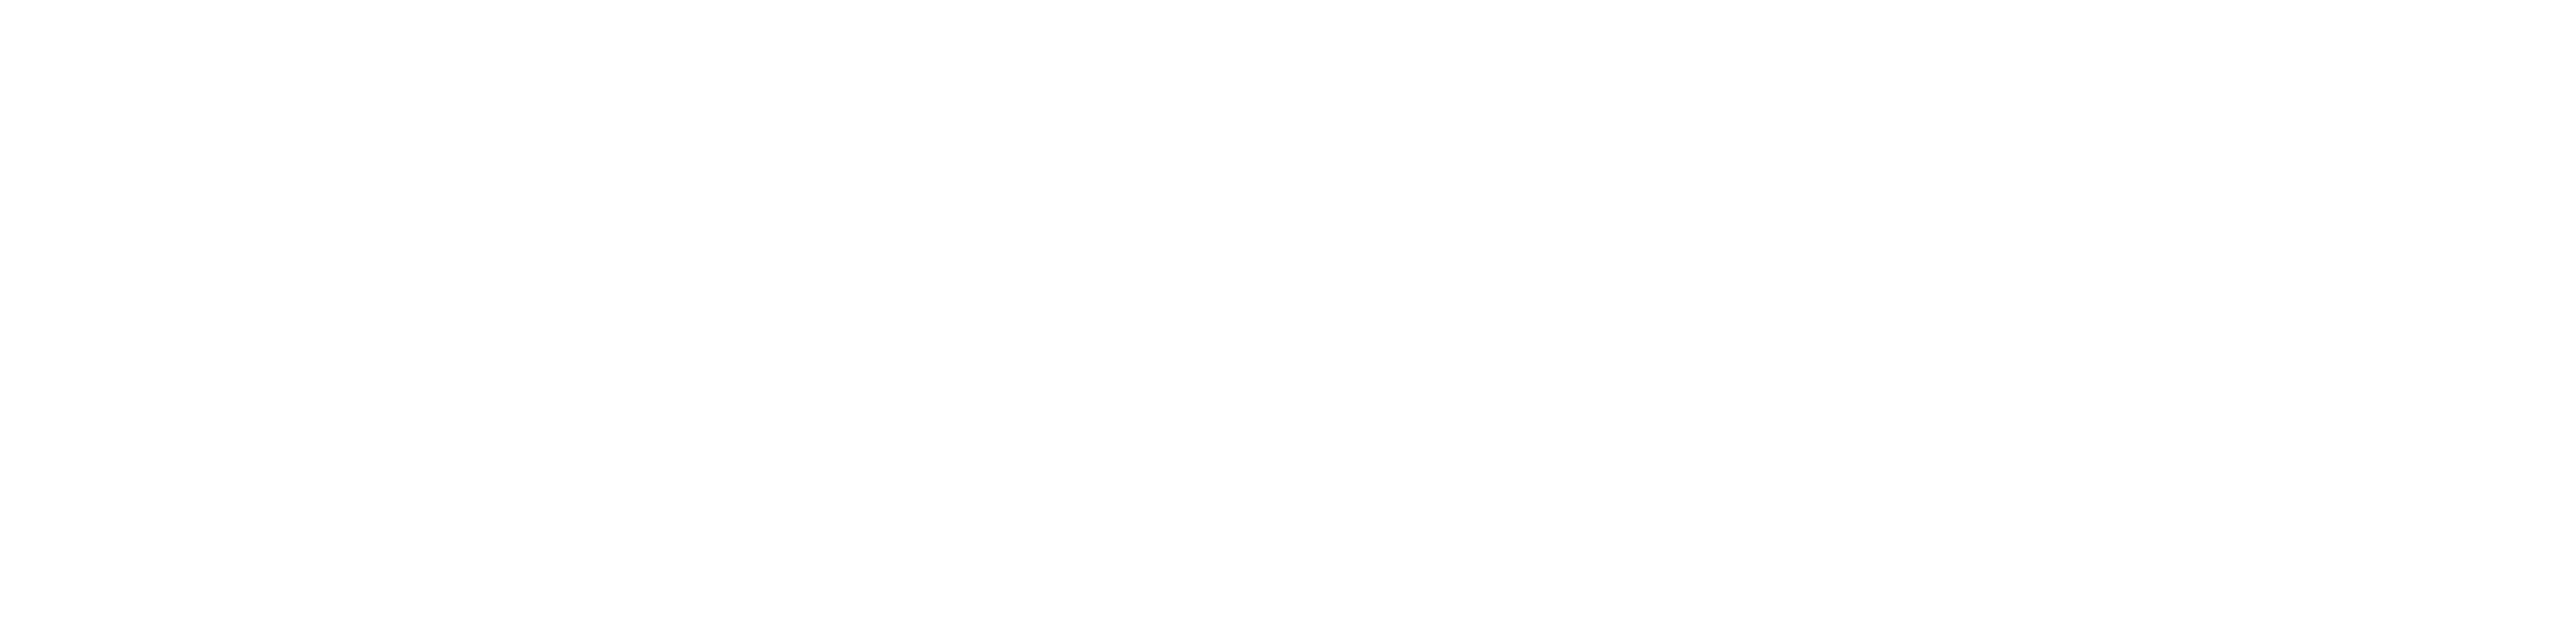

2020-06-04 20:57:00,247 logger INFO loss 0.44, 3D Dis:  0.75mm, shiftDiff: 4893.403320, MemUsed:232.37
2020-06-04 20:57:05,482 logger INFO loss 0.44, 3D Dis:  0.72mm, shiftDiff: 4753.066895, MemUsed:232.37
2020-06-04 20:57:10,921 logger INFO loss 0.44, 3D Dis:  0.70mm, shiftDiff: 4621.464355, MemUsed:232.37
2020-06-04 20:57:16,311 logger INFO loss 0.43, 3D Dis:  0.68mm, shiftDiff: 4500.165039, MemUsed:232.37
2020-06-04 20:57:21,639 logger INFO loss 0.43, 3D Dis:  0.67mm, shiftDiff: 4385.294434, MemUsed:232.37
2020-06-04 20:57:27,028 logger INFO loss 0.43, 3D Dis:  0.65mm, shiftDiff: 4275.238281, MemUsed:232.37
2020-06-04 20:57:32,345 logger INFO loss 0.43, 3D Dis:  0.63mm, shiftDiff: 4169.023438, MemUsed:232.37
2020-06-04 20:57:37,791 logger INFO loss 0.43, 3D Dis:  0.62mm, shiftDiff: 4069.663086, MemUsed:232.37
2020-06-04 20:57:43,142 logger INFO loss 0.43, 3D Dis:  0.60mm, shiftDiff: 3977.287109, MemUsed:232.37
2020-06-04 20:57:48,515 logger INFO loss 0.42, 3D Dis:  0.59mm, shiftDiff

<IPython.core.display.Javascript object>


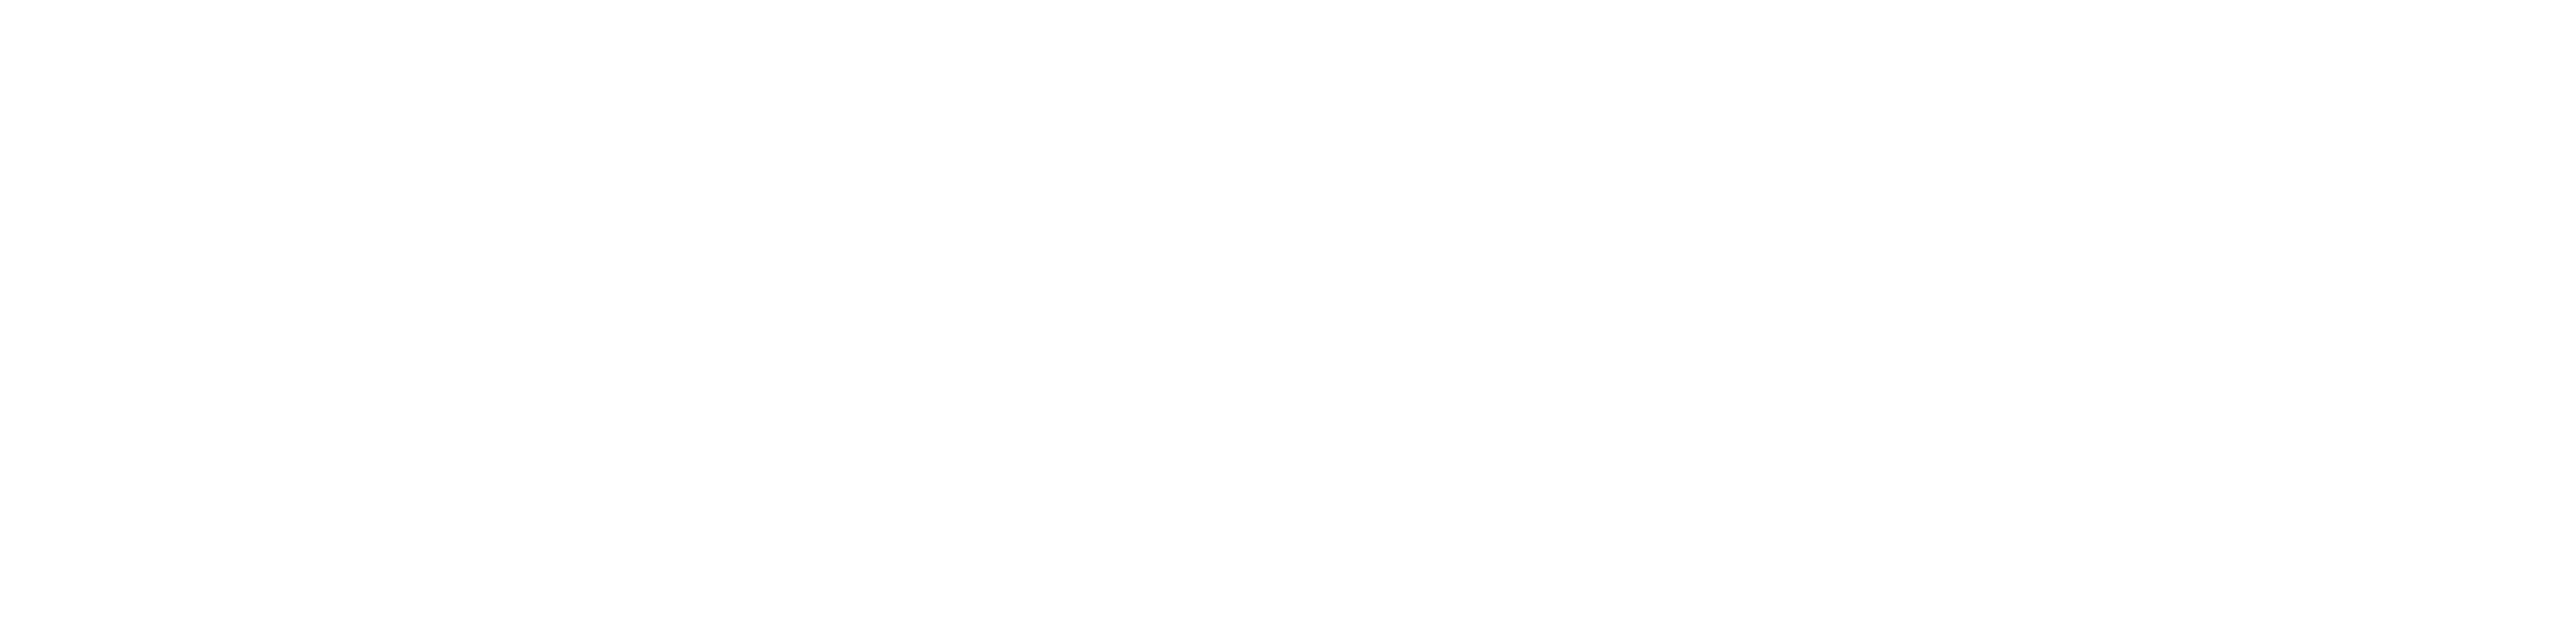

2020-06-04 20:58:10,953 logger INFO loss 0.42, 3D Dis:  0.58mm, shiftDiff: 3811.960205, MemUsed:232.37
2020-06-04 20:58:16,171 logger INFO loss 0.42, 3D Dis:  0.56mm, shiftDiff: 3738.545898, MemUsed:232.37
2020-06-04 20:58:21,549 logger INFO loss 0.42, 3D Dis:  0.55mm, shiftDiff: 3672.022949, MemUsed:232.37
2020-06-04 20:58:26,892 logger INFO loss 0.42, 3D Dis:  0.54mm, shiftDiff: 3612.038818, MemUsed:232.37
2020-06-04 20:58:32,313 logger INFO loss 0.42, 3D Dis:  0.54mm, shiftDiff: 3558.644043, MemUsed:232.37
2020-06-04 20:58:37,641 logger INFO loss 0.42, 3D Dis:  0.53mm, shiftDiff: 3509.238037, MemUsed:232.37
2020-06-04 20:58:43,018 logger INFO loss 0.42, 3D Dis:  0.52mm, shiftDiff: 3461.354492, MemUsed:232.37
2020-06-04 20:58:48,354 logger INFO loss 0.42, 3D Dis:  0.51mm, shiftDiff: 3418.891602, MemUsed:232.37
2020-06-04 20:58:53,787 logger INFO loss 0.41, 3D Dis:  0.51mm, shiftDiff: 3381.306152, MemUsed:232.37
2020-06-04 20:58:59,138 logger INFO loss 0.41, 3D Dis:  0.50mm, shiftDiff

<IPython.core.display.Javascript object>


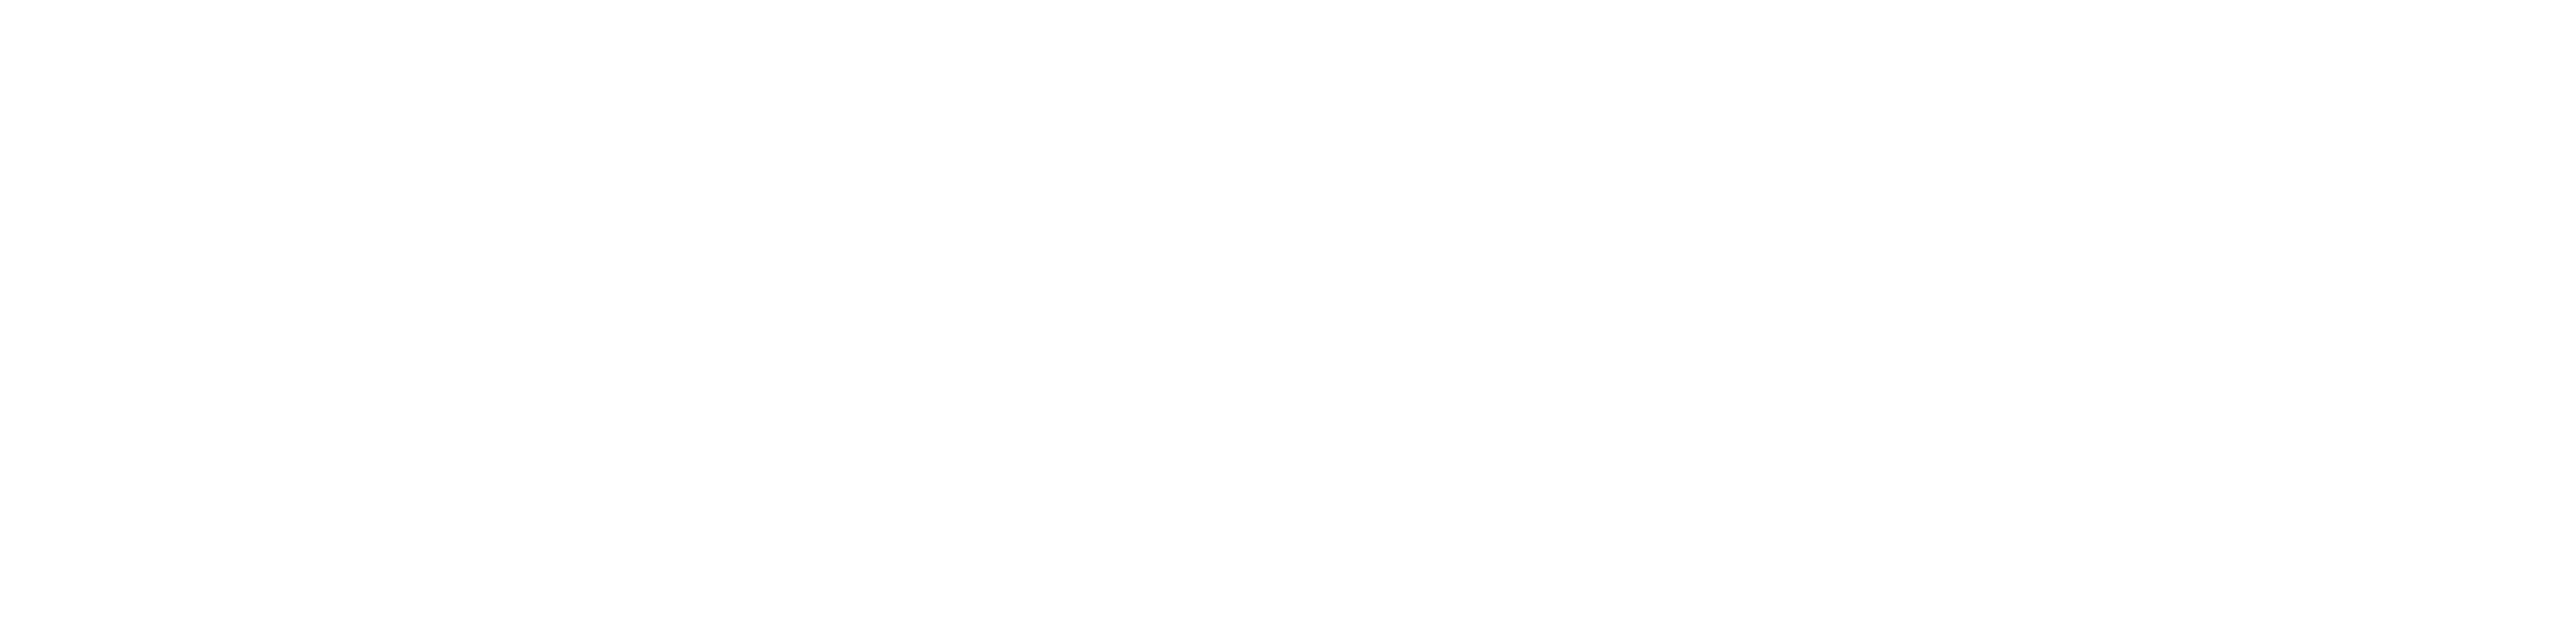

2020-06-04 20:59:21,591 logger INFO loss 0.41, 3D Dis:  0.50mm, shiftDiff: 3313.894287, MemUsed:232.37
2020-06-04 20:59:26,822 logger INFO loss 0.41, 3D Dis:  0.49mm, shiftDiff: 3281.361084, MemUsed:232.37
2020-06-04 20:59:32,145 logger INFO loss 0.41, 3D Dis:  0.49mm, shiftDiff: 3251.014648, MemUsed:232.37
2020-06-04 20:59:37,551 logger INFO loss 0.41, 3D Dis:  0.48mm, shiftDiff: 3221.122070, MemUsed:232.37
2020-06-04 20:59:42,864 logger INFO loss 0.41, 3D Dis:  0.48mm, shiftDiff: 3192.296875, MemUsed:232.37
2020-06-04 20:59:48,245 logger INFO loss 0.41, 3D Dis:  0.47mm, shiftDiff: 3163.785645, MemUsed:232.37
2020-06-04 20:59:53,570 logger INFO loss 0.41, 3D Dis:  0.47mm, shiftDiff: 3135.752441, MemUsed:232.37
2020-06-04 20:59:58,955 logger INFO loss 0.41, 3D Dis:  0.46mm, shiftDiff: 3107.282227, MemUsed:232.37
2020-06-04 21:00:04,316 logger INFO loss 0.41, 3D Dis:  0.46mm, shiftDiff: 3079.035645, MemUsed:232.37
2020-06-04 21:00:09,680 logger INFO loss 0.41, 3D Dis:  0.46mm, shiftDiff

<IPython.core.display.Javascript object>


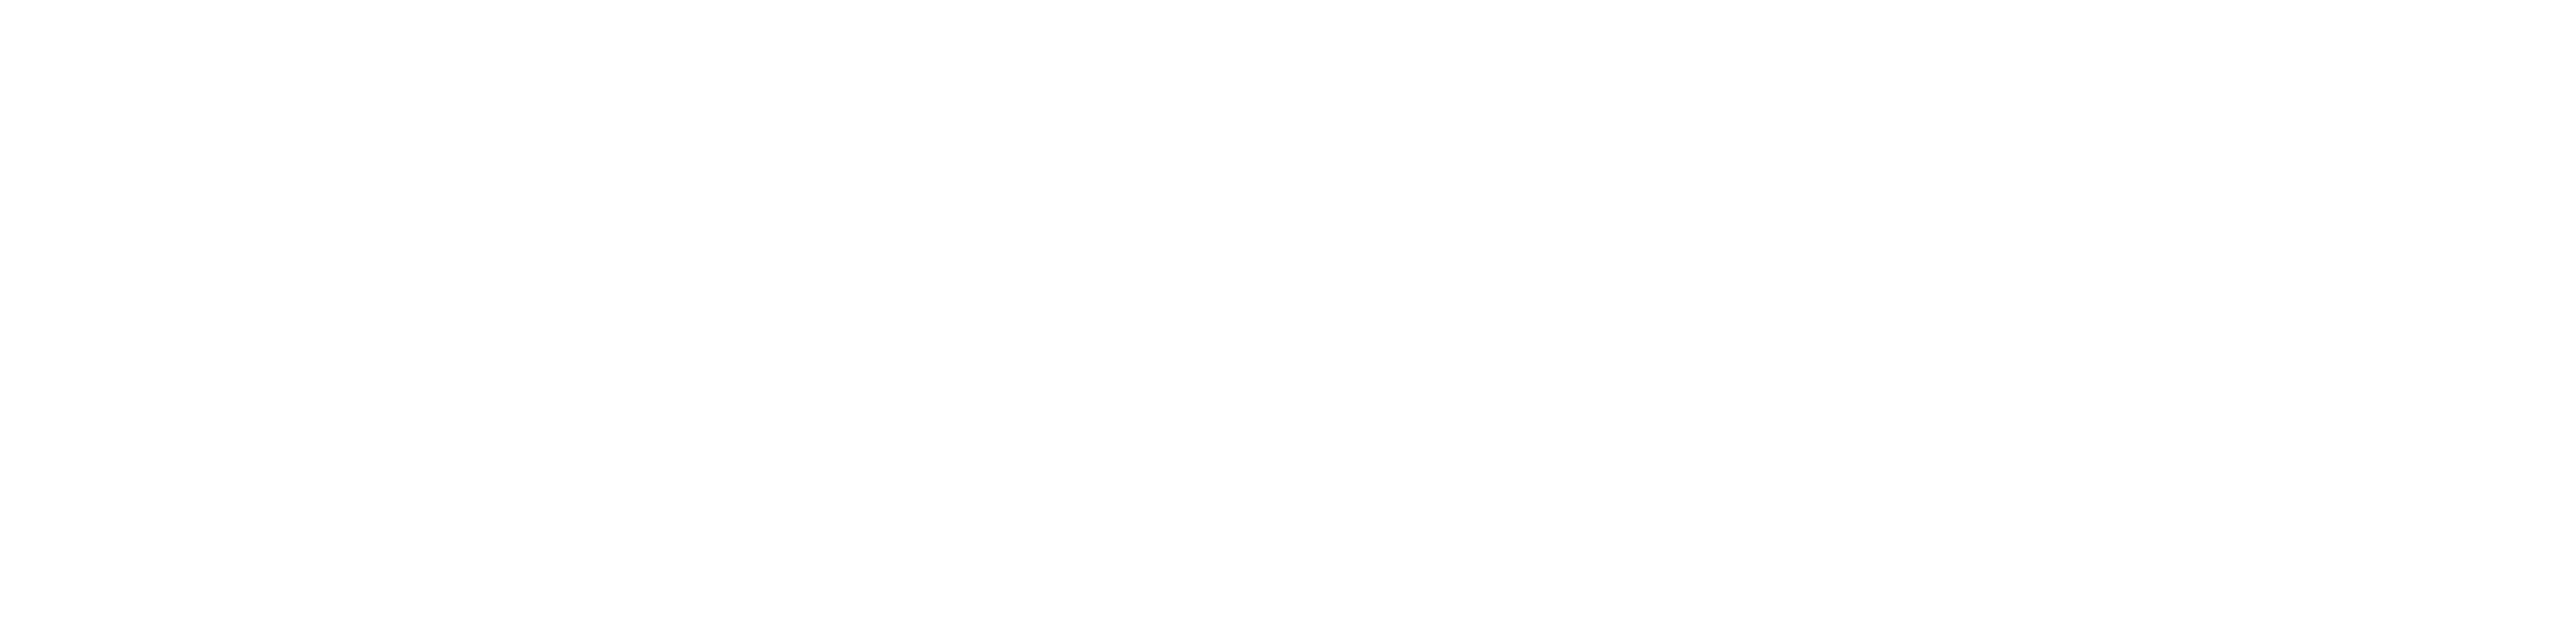

2020-06-04 21:00:32,093 logger INFO loss 0.41, 3D Dis:  0.45mm, shiftDiff: 3024.613281, MemUsed:232.37
2020-06-04 21:00:37,360 logger INFO loss 0.41, 3D Dis:  0.45mm, shiftDiff: 2997.394531, MemUsed:232.37
2020-06-04 21:00:42,776 logger INFO loss 0.41, 3D Dis:  0.44mm, shiftDiff: 2974.144043, MemUsed:232.37
2020-06-04 21:00:48,073 logger INFO loss 0.41, 3D Dis:  0.44mm, shiftDiff: 2955.485840, MemUsed:232.37
2020-06-04 21:00:53,448 logger INFO loss 0.41, 3D Dis:  0.44mm, shiftDiff: 2938.167969, MemUsed:232.37
2020-06-04 21:00:58,861 logger INFO loss 0.40, 3D Dis:  0.44mm, shiftDiff: 2922.984131, MemUsed:232.37
2020-06-04 21:01:04,324 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2911.303711, MemUsed:232.37
2020-06-04 21:01:09,712 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2902.973877, MemUsed:232.37
2020-06-04 21:01:15,139 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2899.369629, MemUsed:232.37
2020-06-04 21:01:20,508 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff

<IPython.core.display.Javascript object>


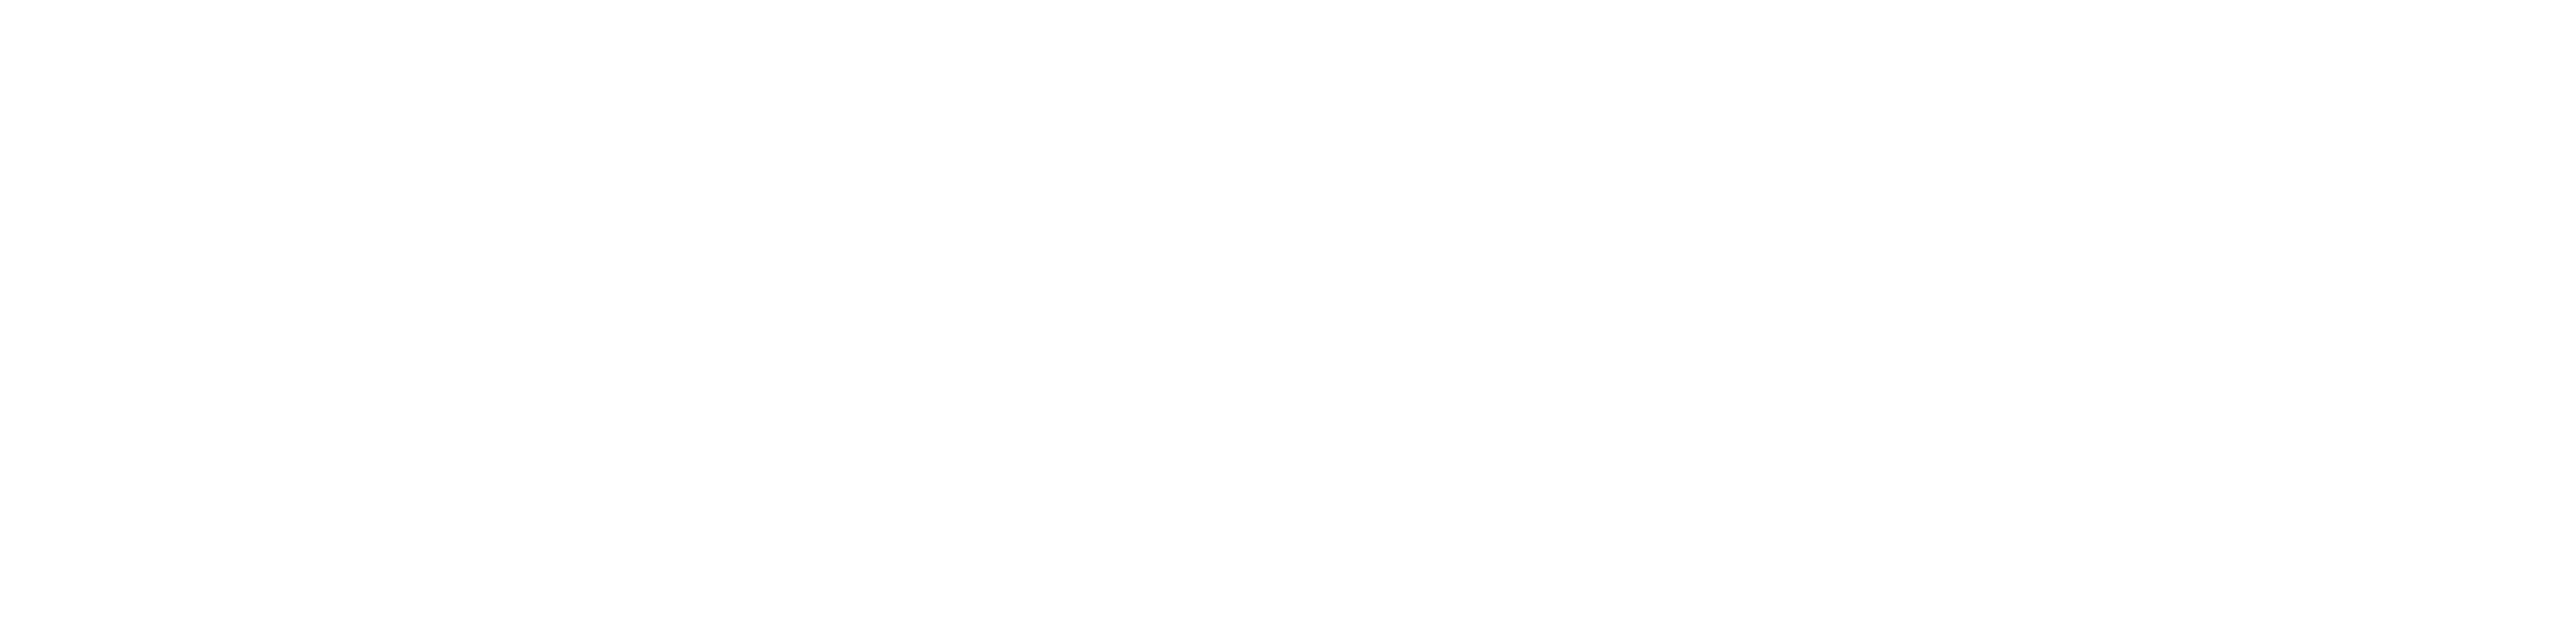

2020-06-04 21:01:42,974 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2897.130859, MemUsed:232.37
2020-06-04 21:01:48,242 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2892.971680, MemUsed:232.37
2020-06-04 21:01:53,687 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2886.802246, MemUsed:232.37
2020-06-04 21:01:59,076 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2879.595947, MemUsed:232.37
2020-06-04 21:02:04,400 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2872.202148, MemUsed:232.37
2020-06-04 21:02:09,783 logger INFO loss 0.40, 3D Dis:  0.43mm, shiftDiff: 2864.548340, MemUsed:232.37
2020-06-04 21:02:15,106 logger INFO loss 0.40, 3D Dis:  0.42mm, shiftDiff: 2855.587402, MemUsed:232.37
2020-06-04 21:02:20,480 logger INFO loss 0.40, 3D Dis:  0.42mm, shiftDiff: 2846.269043, MemUsed:232.37
2020-06-04 21:02:25,891 logger INFO loss 0.40, 3D Dis:  0.42mm, shiftDiff: 2834.952637, MemUsed:232.37
2020-06-04 21:02:31,287 logger INFO loss 0.40, 3D Dis:  0.42mm, shiftDiff

<IPython.core.display.Javascript object>


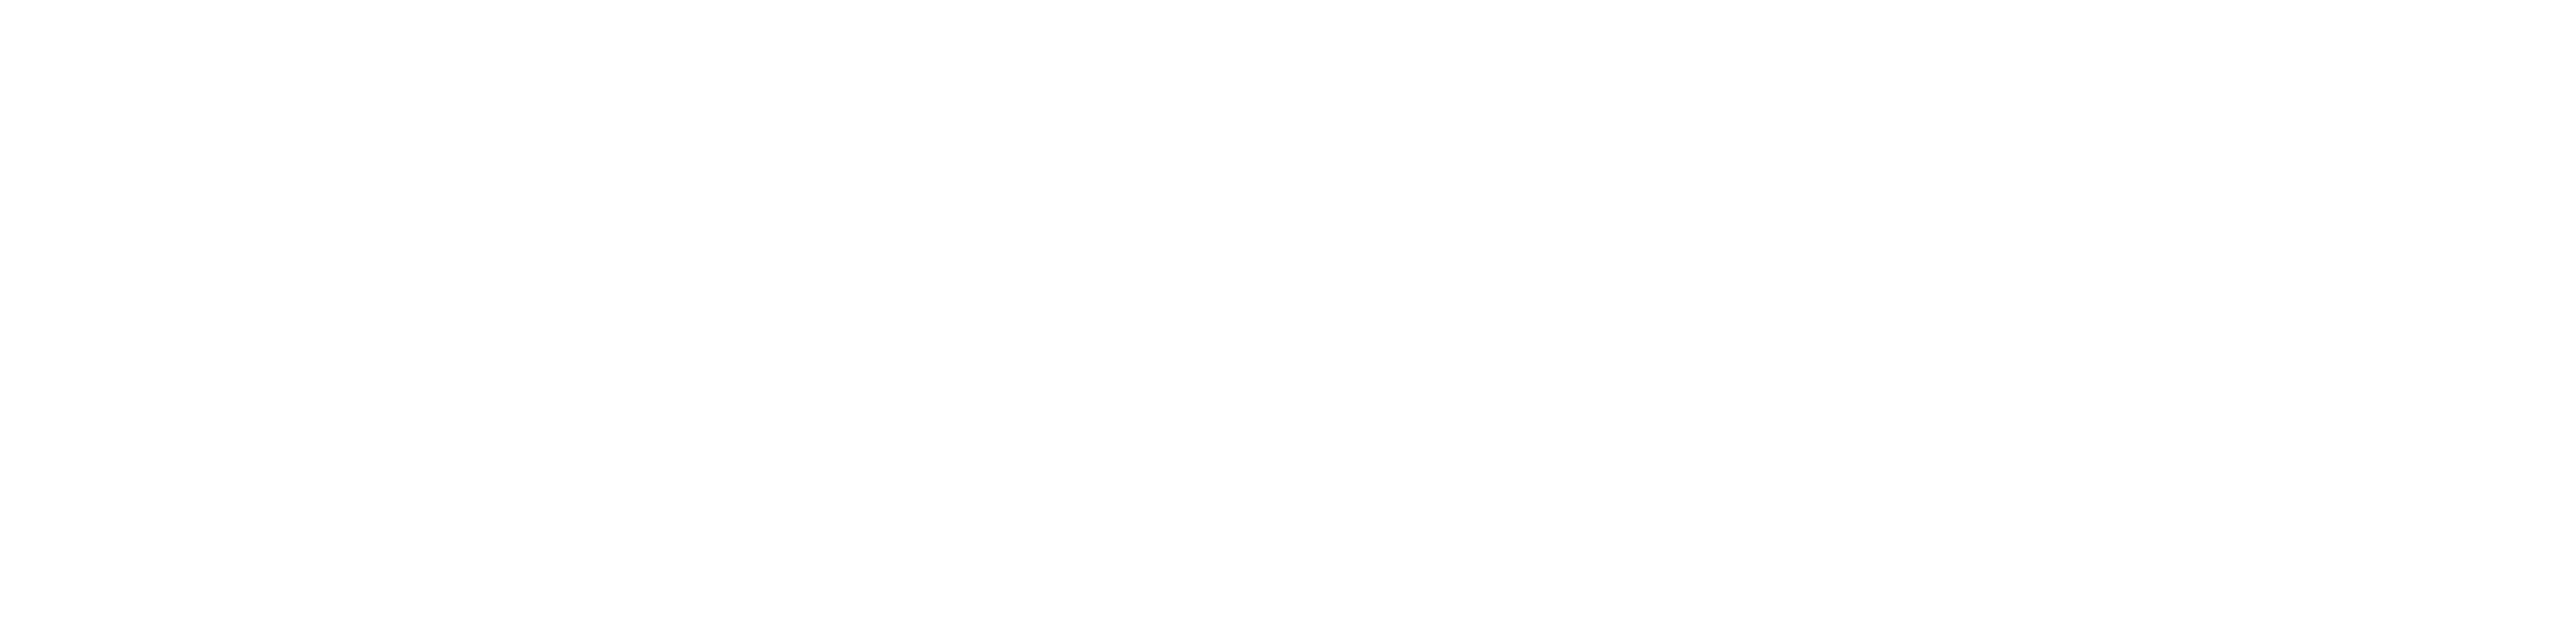

2020-06-04 21:02:53,683 logger INFO loss 0.40, 3D Dis:  0.42mm, shiftDiff: 2809.300537, MemUsed:232.37
2020-06-04 21:02:59,033 logger INFO loss 0.40, 3D Dis:  0.42mm, shiftDiff: 2795.791016, MemUsed:232.37
2020-06-04 21:03:04,461 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2783.588623, MemUsed:232.37
2020-06-04 21:03:09,841 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2774.894775, MemUsed:232.37
2020-06-04 21:03:15,190 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2769.613525, MemUsed:232.37
2020-06-04 21:03:20,527 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2766.159180, MemUsed:232.37
2020-06-04 21:03:25,901 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2763.278320, MemUsed:232.37
2020-06-04 21:03:31,305 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2760.538574, MemUsed:232.37
2020-06-04 21:03:36,712 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2757.147705, MemUsed:232.37
2020-06-04 21:03:42,095 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff

<IPython.core.display.Javascript object>


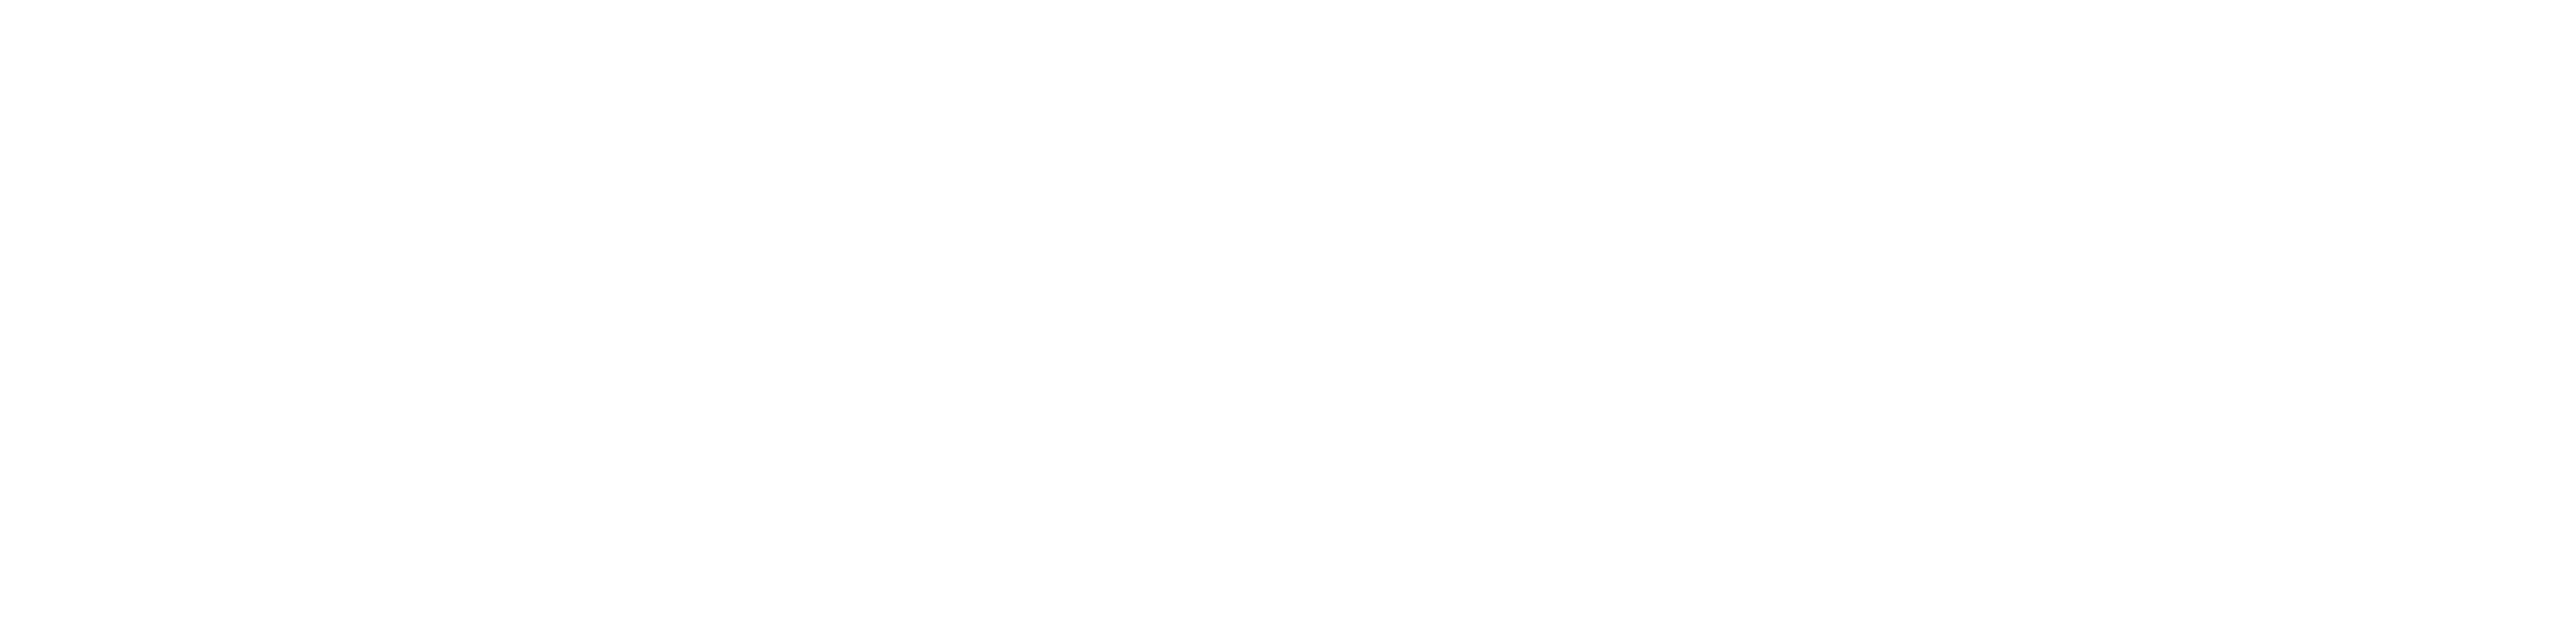

2020-06-04 21:04:04,521 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2747.137695, MemUsed:232.37
2020-06-04 21:04:09,839 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2742.704590, MemUsed:232.37
2020-06-04 21:04:15,211 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2738.265381, MemUsed:232.37
2020-06-04 21:04:20,526 logger INFO loss 0.40, 3D Dis:  0.41mm, shiftDiff: 2733.005371, MemUsed:232.37
2020-06-04 21:04:25,849 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff: 2727.074707, MemUsed:232.37
2020-06-04 21:04:31,249 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff: 2720.700928, MemUsed:232.37
2020-06-04 21:04:36,569 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff: 2713.328613, MemUsed:232.37
2020-06-04 21:04:41,935 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff: 2705.699219, MemUsed:232.37
2020-06-04 21:04:47,292 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff: 2698.426270, MemUsed:232.37
2020-06-04 21:04:52,666 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff

<IPython.core.display.Javascript object>


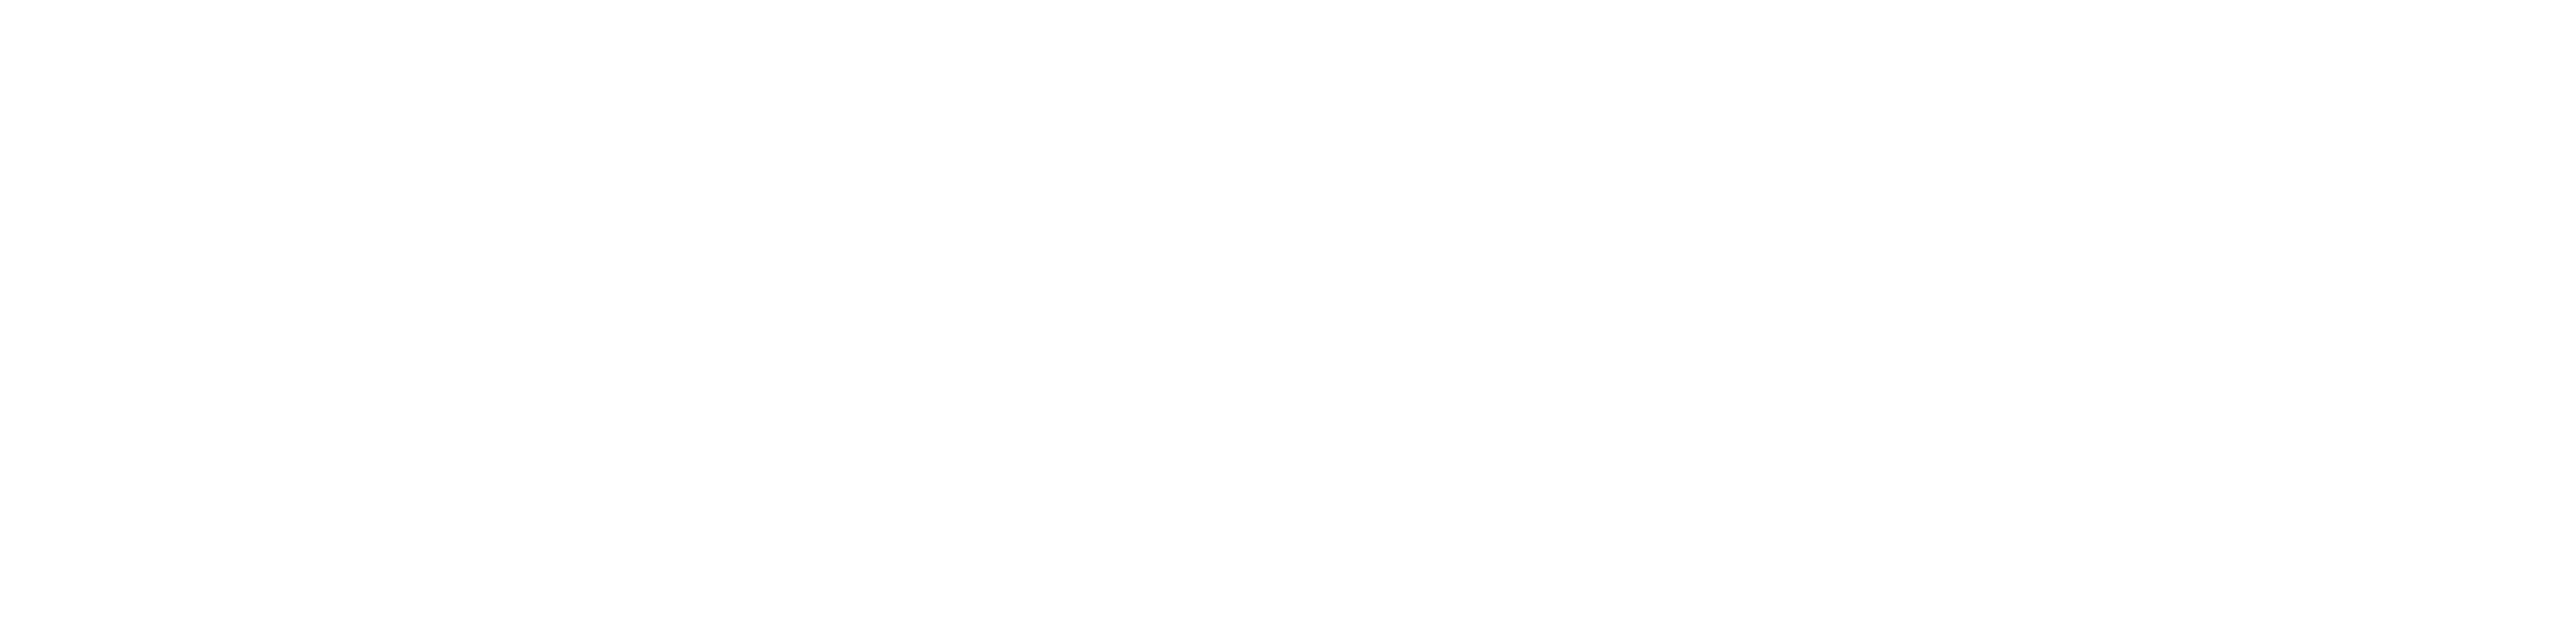

2020-06-04 21:05:15,137 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff: 2681.820801, MemUsed:232.37
2020-06-04 21:05:20,417 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff: 2672.757080, MemUsed:232.37
2020-06-04 21:05:25,859 logger INFO loss 0.40, 3D Dis:  0.40mm, shiftDiff: 2664.032227, MemUsed:232.37
2020-06-04 21:05:31,215 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff: 2655.357422, MemUsed:232.37
2020-06-04 21:05:36,601 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff: 2646.267578, MemUsed:232.37
2020-06-04 21:05:41,942 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff: 2638.078125, MemUsed:232.37
2020-06-04 21:05:47,327 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff: 2630.171143, MemUsed:232.37
2020-06-04 21:05:52,738 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff: 2622.313477, MemUsed:232.37
2020-06-04 21:05:58,203 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff: 2614.887451, MemUsed:232.37
2020-06-04 21:06:03,573 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff

<IPython.core.display.Javascript object>


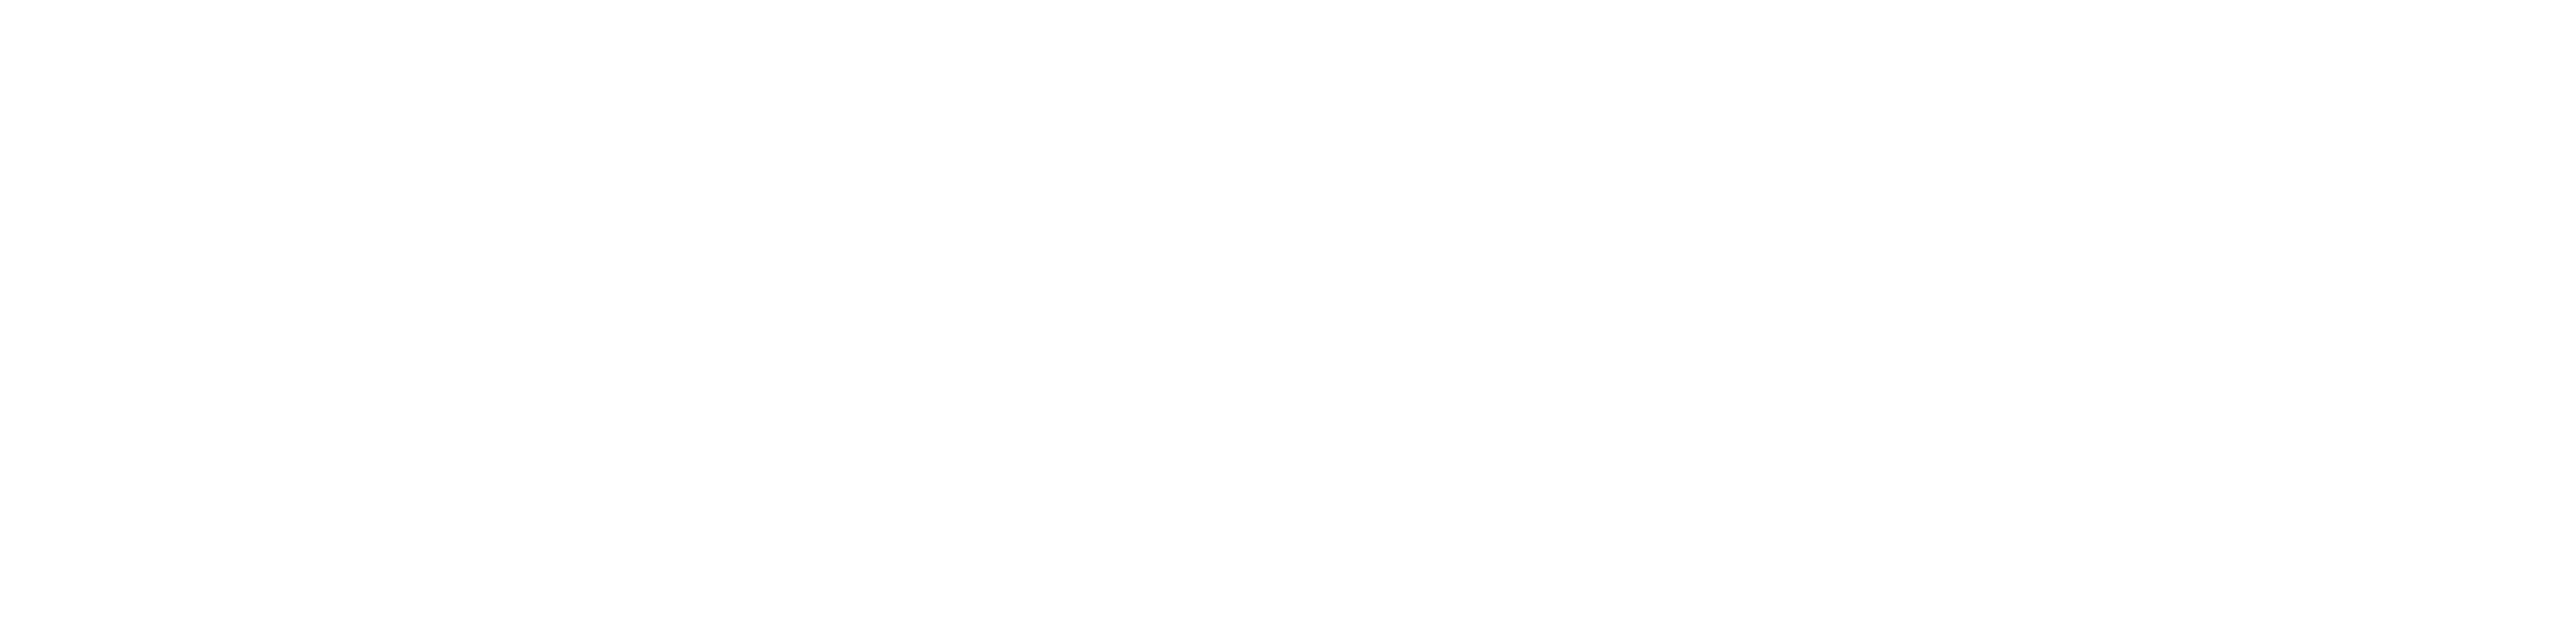

2020-06-04 21:06:26,022 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff: 2601.528809, MemUsed:232.37
2020-06-04 21:06:31,287 logger INFO loss 0.40, 3D Dis:  0.39mm, shiftDiff: 2596.852051, MemUsed:232.37
2020-06-04 21:06:36,690 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2593.137695, MemUsed:232.37
2020-06-04 21:06:42,050 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2589.047607, MemUsed:232.37
2020-06-04 21:06:47,362 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2586.010010, MemUsed:232.37
2020-06-04 21:06:52,737 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2583.878662, MemUsed:232.37
2020-06-04 21:06:58,108 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2582.205322, MemUsed:232.37
2020-06-04 21:07:03,548 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2580.016113, MemUsed:232.37
2020-06-04 21:07:08,958 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2577.606445, MemUsed:232.37
2020-06-04 21:07:14,315 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff

<IPython.core.display.Javascript object>


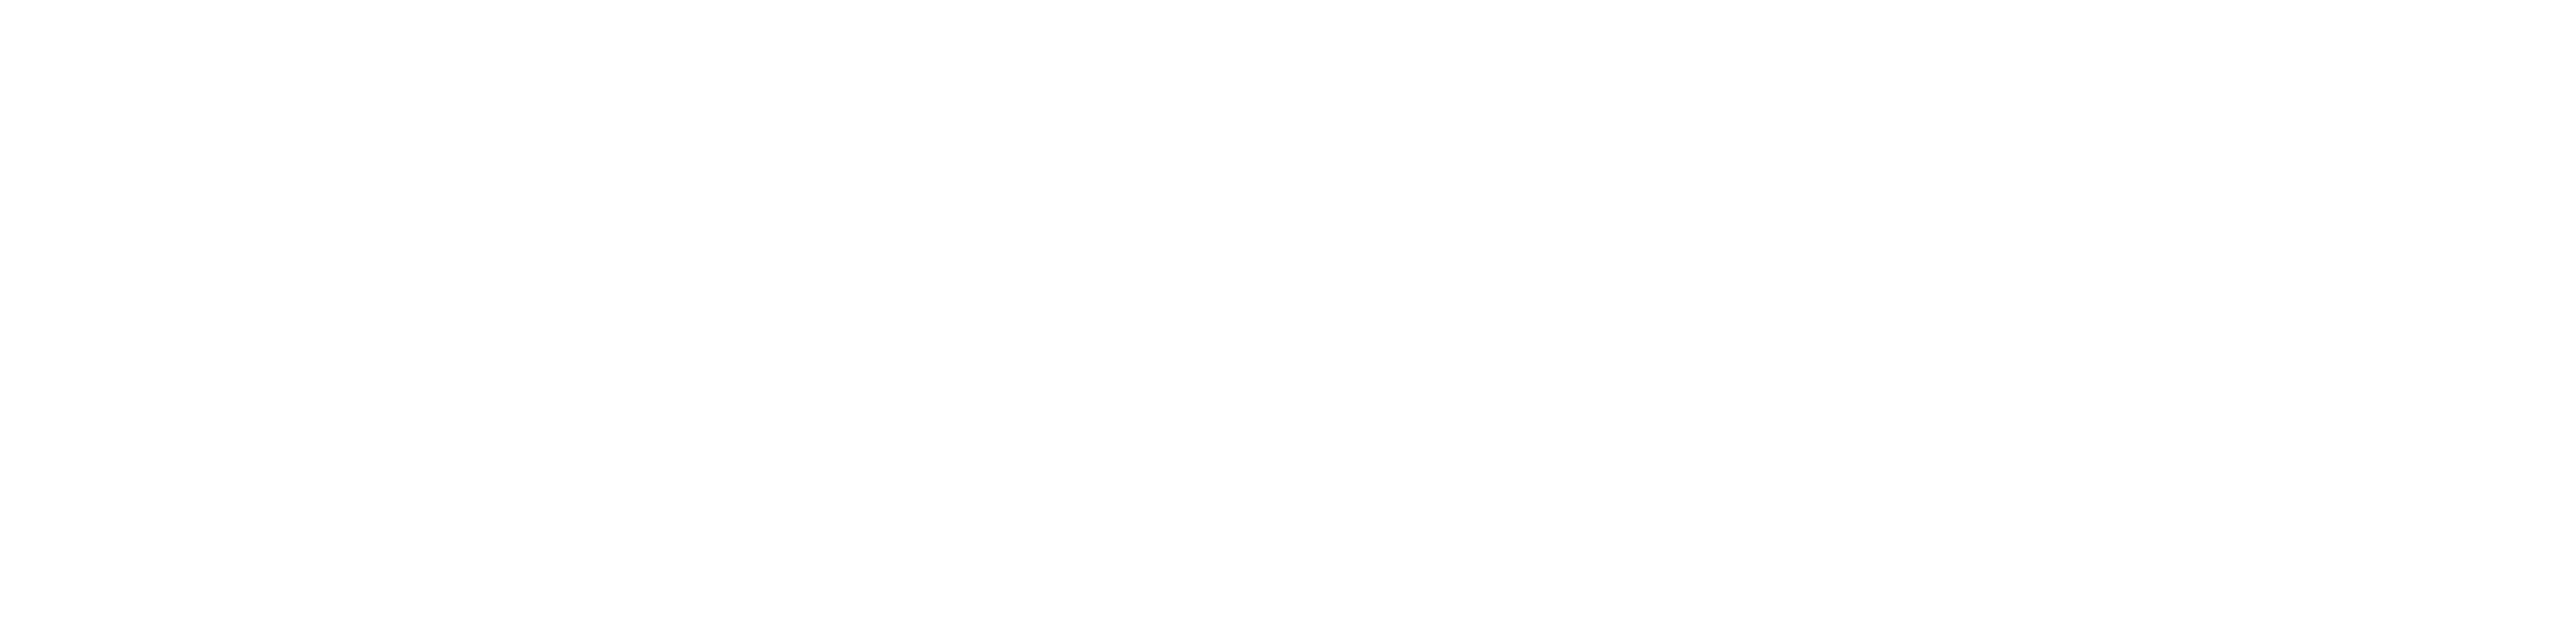

2020-06-04 21:07:36,753 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2572.169189, MemUsed:232.37
2020-06-04 21:07:41,998 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2569.814209, MemUsed:232.37
2020-06-04 21:07:47,472 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2567.651123, MemUsed:232.37
2020-06-04 21:07:52,792 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2565.437744, MemUsed:232.37
2020-06-04 21:07:58,180 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2563.145020, MemUsed:232.37
2020-06-04 21:08:03,536 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2560.804688, MemUsed:232.37
2020-06-04 21:08:08,911 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2557.965820, MemUsed:232.37
2020-06-04 21:08:14,273 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2555.042480, MemUsed:232.37
2020-06-04 21:08:19,704 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2552.165771, MemUsed:232.37
2020-06-04 21:08:25,076 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff

<IPython.core.display.Javascript object>


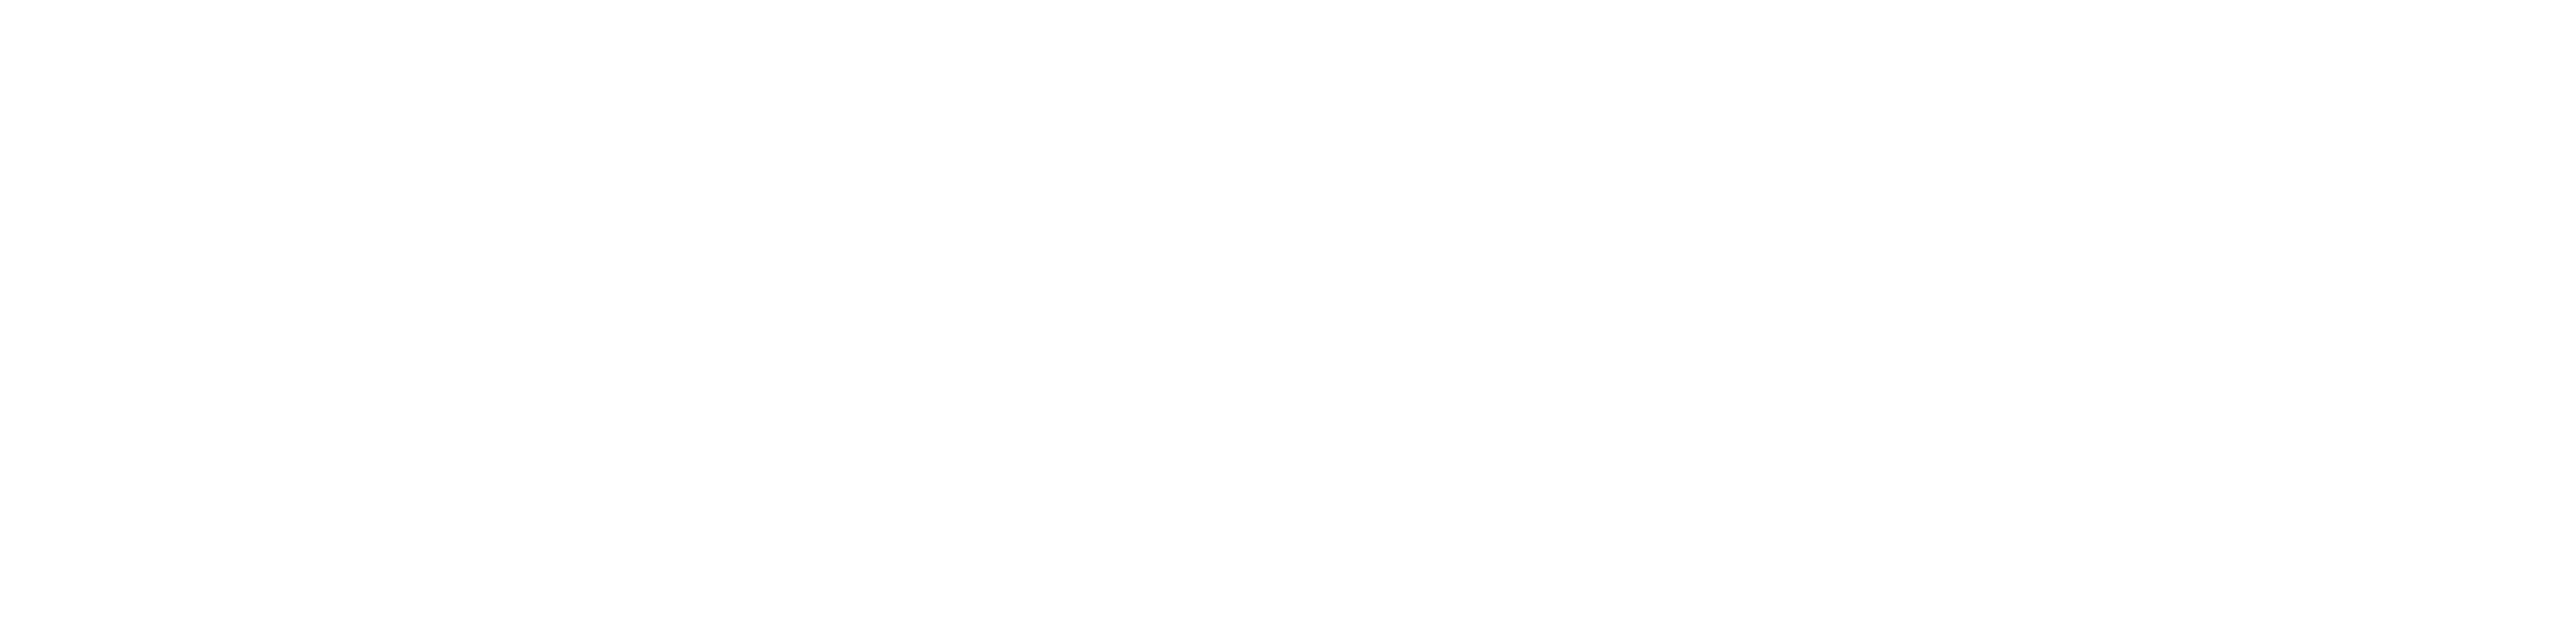

2020-06-04 21:08:47,552 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2547.689941, MemUsed:232.37
2020-06-04 21:08:52,866 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2545.834961, MemUsed:232.37
2020-06-04 21:08:58,257 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2544.401367, MemUsed:232.37
2020-06-04 21:09:03,726 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2543.755371, MemUsed:232.37
2020-06-04 21:09:09,043 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2542.970215, MemUsed:232.37
2020-06-04 21:09:14,433 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2542.232666, MemUsed:232.37
2020-06-04 21:09:19,811 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2541.007812, MemUsed:232.37
2020-06-04 21:09:25,241 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2540.422852, MemUsed:232.37
2020-06-04 21:09:30,618 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2539.749023, MemUsed:232.37
2020-06-04 21:09:36,045 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff

<IPython.core.display.Javascript object>

2020-06-04 21:09:58,463 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2540.085693, MemUsed:232.37
2020-06-04 21:10:03,734 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2540.274414, MemUsed:232.37
2020-06-04 21:10:09,229 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2539.456055, MemUsed:232.37
2020-06-04 21:10:14,555 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2538.914307, MemUsed:232.37
2020-06-04 21:10:19,943 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2538.677246, MemUsed:232.37
2020-06-04 21:10:25,316 logger INFO loss 0.40, 3D Dis:  0.38mm, shiftDiff: 2537.604736, MemUsed:232.37



KeyboardInterrupt: 

In [37]:
cfg.numIterations = 300
loop = tqdm_notebook(range(cfg.numIterations))
saveVTK(join(outFolderMesh, 'Target.vtk'), modifiedVertsRef.cpu().detach().numpy(), smplshExampleMesh)
for i in loop:
    optimizer.zero_grad()
#     torch.cuda.empty_cache()

    lossVal = 0
    for iCam in range(cfg.numCams):
        refImg = torch.tensor(imagesRef[iCam][..., 3], dtype=torch.float64, device=device, requires_grad=False)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        images = renderSynth.renderer(mesh, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss = 1 - torch.norm(refImg * images[..., 3], p=1) / torch.norm(refImg + images[..., 3] - refImg * images[..., 3], p=1)
        
        loss.backward()
        lossVal += loss.item()
        #showCudaMemUsage(device)
    
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
    loss = cfg.normalSmootherW * mesh_normal_consistency(mesh)
    
#     print("Laplacian on normal shift",  cfg.lpSmootherW * normalShift.transpose(0,1) @ LNP @ normalShift)
    
    # Laplacian on shift in normal direction
    loss = loss + cfg.lpSmootherW * normalShift.transpose(0,1) @ LNP @ normalShift
    
    loss.backward()
    lossVal += loss.item()
    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # recordData
    losses.append(lossVal)
    
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    torch.cuda.empty_cache()

    dis3D = modifiedVerts.cpu().detach().numpy() - modifiedVertsRef.cpu().numpy()
    dis3D = np.mean(np.sqrt(dis3D[:,0]**2 + dis3D[:,1]**2 + dis3D[:,2]**2))
    
    infoStr = 'loss %.2f, 3D Dis:  %.2fmm, shiftDiff: %.6f, MemUsed:%.2f' \
        % (lossVal, dis3D, torch.sum(torch.abs(normalShift - cfg.normalShiftLevel)).item(), memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    #if lossVal < cfg.terminateLoss:
    #    break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        showCudaMemUsage(device)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        

        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        diffImages = []
        with torch.no_grad():
            for iCam in range(len(cams)):
                image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
#                 images.append(image_cur.cpu().detach().numpy())
                imgDiff = np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
                diffImages.append(imgDiff)
            torch.cuda.empty_cache()

#             showCudaMemUsage(device)
        visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)


In [ ]:
diffImages[0].shape

In [ ]:
np.max(diffImages[0])

In [ ]:
if True:
    showCudaMemUsage(device)
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
            verts=[modifiedVerts],   
            faces=[faces_idx], 
        )
    
    torch.cuda.empty_cache()
    plt.close('all')
    
    outImgFile = join(outFolderForExperiment, 'Fig_' + str(0).zfill(5) + '.png')
    diffImages = []
    with torch.no_grad():
        for iCam in range(len(cams)):
            image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
            imgDiff =  np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
            diffImages.append(imgDiff)
    visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
    
    saveVTK(join(outFolderMesh, 'Fit' + str(0).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)